In [237]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
# import visualkeras

import datetime
import ephem

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pypalettes 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import json
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfea
import pyproj
import imageio.v2 as imageio
from io import BytesIO
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from scipy.stats import gaussian_kde, anderson_ksamp, cramervonmises_2samp
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import genextreme as gev
from scipy.stats import genpareto

import custom_functions as cf
import custom_for_model as cfm
import custom_generator as cgen
import pickle


from pyextremes import get_extremes
from pyextremes import plot_mean_residual_life
from pyextremes import EVA

palette = "Prism"
# cmap = pypalettes.load_cmap(palette, type="continuous", keep=[True, True, True, True, True, True, True])
palette_hex_list = pypalettes.get_hex(palette)
cmap_name = 'cmap_sealevel'
cmap_hex_list = [palette_hex_list[5],palette_hex_list[6],palette_hex_list[2],palette_hex_list[1],palette_hex_list[0]]
rgb_colors = [mcolors.hex2color(color) for color in cmap_hex_list]
cmap = LinearSegmentedColormap.from_list(cmap_name, rgb_colors, N=256)

# Load settings
with open('settings.json', 'r') as file:
    settings = json.load(file)

2.16.1


**Prism pypalette**<br>
<img src="Data/prism.png" alt="prism" width="300"/>

In [238]:
data_path= settings["data_path"]
output_path=settings["output_path"]
img_path=settings["img_path"]
local_data_path= os.getcwd()+'/Data/'

lat = settings["lat"]
lon = settings["lon"]

In [239]:
train_y_bounds = settings["train_y_bounds"]
train_month_start_end = settings["train_month_start_end"]
LSTM_recurrent_steps = settings["LSTM_recurrent_steps"]
ms_recurrent_steps = settings["ms_recurrent_steps"]
output_type = bool(settings["output_type"])
preprocess = settings["preprocess"]
kfold = bool(settings["kfold"])
folds_number = settings["folds_number"]

if output_type:
   y_shape=2
else:
   y_shape=1

model_type = settings["model_type"]  # can be: conv, lstm, conv-lstm
# constrain n_recurrent_setps equal for each variable for lstm and conv-lstm
if (model_type=="lstm" or model_type=="conv-lstm"):
   LSTM_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)
   ms_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)

seed=42

In [240]:
# LE TRAIETTORIE SONO DELLA SECONDA COMBINAZIONE!


# # NY best surge and best tide (regression) - dense vs conv3d for surge (?)
models_to_analyze = [["dense_5folds_bbox11_steps240_loss_mse", "dense_5folds_bbox11_steps240_loss_mcql2"],
                      ["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox1015_steps24_loss_mse"],
                      ["conv_5folds_bbox1015_steps24_loss_mcql2", "dense_5folds_bbox11_steps240_loss_mcql2"]]

# models_to_analyze = [["dense_5folds_bbox11_steps240_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"],
#                       ["conv_5folds_bbox1015_steps24_loss_mse", "conv_5folds_bbox1015_steps24_loss_mse"],
#                       ["conv_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"]]

#  NY best surge and best tide (regression) - dense vs conv3d for surge (?)
# models_to_analyze = [["dense_5folds_bbox11_steps240_loss_mcql", "dense_5folds_bbox11_steps240_loss_mcql"],
#                        ["conv3D_5folds_bbox1015_steps24_loss_mcql", "conv3D_5folds_bbox1015_steps24_loss_mcql"],
#                        ["conv3D_5folds_bbox1015_steps24_loss_mcql", "dense_5folds_bbox11_steps240_loss_mcql"]]
#  NY best surge and best tide (regression) - dense vs conv3d for surge (?)
# models_to_analyze = [["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"],
#                        ["conv3D_5folds_bbox1015_steps24_loss_mcql", "dense_5folds_bbox11_steps240_loss_mcql"]]




#BEIRA best surge and best tide (regression) - circa
# models_to_analyze = [["lstm_5folds_bbox11_steps240_loss_mse", "lstm_5folds_bbox11_steps240_loss_mse"],
#                     ["conv3d_5folds_bbox1015_steps24_loss_mse", "lstm_5folds_bbox11_steps240_loss_mse"]]

# models_to_analyze = [["lstm_5folds_bbox11_steps240_loss_mcql", "lstm_5folds_bbox11_steps240_loss_mcql"],
#                     ["conv3d_5folds_bbox1015_steps24_loss_mcql", "lstm_5folds_bbox11_steps240_loss_mcql"]]

# OSAKA
# models_to_analyze = [["dense_5folds_bbox11_steps240_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"],
#                       ["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox1015_steps24_loss_mse"],
#                       ["dense_5folds_bbox1015_steps24_loss_mse", "dense_5folds_bbox11_steps240_loss_mse"]]


out_variables=["only tide", "storm surge"]

In [241]:
if preprocess=="normalize":
    with open(local_data_path+'kfold_global_min.pkl', 'rb') as file:
        kfold_global_min = pickle.load(file)
    with open(local_data_path+'kfold_global_max.pkl', 'rb') as file:
        kfold_global_max = pickle.load(file)

if preprocess=="standardize":
    with open(local_data_path+'kfold_global_mean_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'rb') as file:
        kfold_global_mean = pickle.load(file)
    with open(local_data_path+'kfold_global_std_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'rb') as file:
        kfold_global_std = pickle.load(file)

if preprocess=="robustscaling":
    with open(local_data_path+'kfold_global_mean.pkl', 'rb') as file:
        kfold_global_mean = pickle.load(file)
    with open(local_data_path+'kfold_global_iqr.pkl', 'rb') as file:
        kfold_global_iqr = pickle.load(file)

## Regression metrics

## __________________________________________________________________________________________________________

In [242]:
def quantile_loss(y_true, y_pred, quantile):
    return tf.maximum(quantile * (y_true - y_pred), (1-quantile) * (y_pred - y_true))

def composite_quantile_loss(y_true, y_pred, quantiles):
    N = y_true.shape[0]
    K = len(quantiles)
    loss = 0
    for k in range(K):
        tau = quantiles[k]
        loss += tf.reduce_sum(quantile_loss(y_true, y_pred, tau)).numpy()
    composite_loss = loss / (N * K)
    return composite_loss

def ratio_of_99th_quantiles(y1, y2,quantile_for_ratio):
    q99_y1 = np.percentile(y1, quantile_for_ratio)
    q99_y2 = np.percentile(y2, quantile_for_ratio)
    if q99_y2 == 0:
        raise ValueError("y2 quantile is 0")
    return q99_y1 / q99_y2

quantiles = [0.75, 0.95]
quantile_for_ratio=0.99



#### Cronological order of k-folds

In [243]:
# _________________________LOAD_INDICIES_____________________________________________________
# load
train_val_indices = np.load(local_data_path+'train_val_indices.npy')
test_indices = np.load(local_data_path+'test_indices.npy')
arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
k = 0

start_date = '1979-02-01 00:00'  # Data e ora di inizio
end_date = '2018-12-31 23:00'    # Data e ora di fine

date_range = pd.date_range(start=start_date, end=end_date, freq='h')
date_array = date_range.to_numpy()  # Converte l'oggetto DatetimeIndex in un array numpy

# Specifica dei nomi delle colonne
column_names = ['k1_val', 'k2_val', 'k3_val', 'k4_val', 'k5_val', 'k1_test', 'k2_test', 'k3_test', 'k4_test', 'k5_test']
df_surge = pd.DataFrame(index=date_range, columns=column_names)
df_surge[:] = np.nan
df_tide = pd.DataFrame(index=date_range, columns=column_names)
df_tide[:] = np.nan
df_surge_pred = pd.DataFrame(index=date_range, columns=column_names)
df_surge_pred[:] = np.nan
df_tide_pred = pd.DataFrame(index=date_range, columns=column_names)
df_tide_pred[:] = np.nan


In [244]:
# Additional score MAE or RMSE
additional_score = "RMSE"
test_scores = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
val_scores = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
train_scores = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]

test_scores_tide = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
val_scores_tide = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
train_scores_tide = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]

test_scores_surge = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
val_scores_surge = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
train_scores_surge = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]

test_scores_wl = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
val_scores_wl = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]
train_scores_wl = [[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]]


for i in range(len(models_to_analyze)):

    # _________________________LOAD_INDICIES_____________________________________________________
    # load
    train_val_indices = np.load(local_data_path+'train_val_indices.npy')
    test_indices = np.load(local_data_path+'test_indices.npy')
    arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
    arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
    k = 0
    # _________________________LOAD_INDICIES_____________________________________________________

    for fold in range(folds_number):
        k = k+1
        # Usa gli indici generati da KFold per creare i set di training e validation
        date_train_val, date_test= date_array[train_val_indices], date_array[test_indices]
        train_array_name = f'train_indices_fold_{k}'
        val_array_name = f'val_indices_fold_{k}'
        date_train, date_val = date_array[arrays_train_indicies[train_array_name].astype(int)], date_array[arrays_val_indicies[val_array_name].astype(int)]
 
        # Load y
        y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_train= np.load(y_train_name)
        if preprocess=="standardize":
            y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

        y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_val=np.load(y_val_name)
        if preprocess=="standardize":
            y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

        df_surge.loc[date_val, f'k{k}_val'] = y_val[:,1]
        df_tide.loc[date_val, f'k{k}_val'] = y_val[:,0]

        y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_test=np.load(y_test_name)
        if preprocess=="standardize":
            y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

        df_surge.loc[date_test, f'k{k}_test'] = y_test[:,1]
        df_tide.loc[date_test, f'k{k}_test'] = y_test[:,0]

        # Load inferenced values
        model_type = models_to_analyze[i][0] # surge model
        model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
        y_name = model_path+"y_train_k"+str(fold)+"_predict.npy"
        y_train_predict=np.load(y_name)  

        model_type = models_to_analyze[i][1] # tide model
        model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
        y_name = model_path+"y_train_k"+str(fold)+"_predict.npy"
        tmp_y_train_predict=np.load(y_name)  
        y_train_predict[:,0]=tmp_y_train_predict[:,0]
        del tmp_y_train_predict

        if preprocess=="standardize":
            y_train_predict[:,0] = y_train_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_train_predict[:,1] = y_train_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])  
        # MSE
        train_scores[fold][0].append(mean_squared_error(y_train,y_train_predict))
        train_scores_tide[fold][0].append(mean_squared_error(y_train[:,0],y_train_predict[:,0]))
        train_scores_surge[fold][0].append(mean_squared_error(y_train[:,1],y_train_predict[:,1]))
        train_scores_wl[fold][0].append(mean_squared_error(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1]))
        # monotone composite quantile loss
        train_scores[fold][1].append(composite_quantile_loss(y_train,y_train_predict,quantiles))
        train_scores_tide[fold][1].append(composite_quantile_loss(y_train[:,0],y_train_predict[:,0],quantiles))
        train_scores_surge[fold][1].append(composite_quantile_loss(y_train[:,1],y_train_predict[:,1],quantiles))
        train_scores_wl[fold][1].append(composite_quantile_loss(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1],quantiles))
        # quantile ratio
        train_scores[fold][2].append(ratio_of_99th_quantiles(y_train,y_train_predict,quantile_for_ratio))
        train_scores_tide[fold][2].append(ratio_of_99th_quantiles(y_train[:,0],y_train_predict[:,0],quantile_for_ratio))
        train_scores_surge[fold][2].append(ratio_of_99th_quantiles(y_train[:,1],y_train_predict[:,1],quantile_for_ratio))
        train_scores_wl[fold][2].append(ratio_of_99th_quantiles(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1],quantile_for_ratio))
        if additional_score=="MAE":
            # MAE
            train_scores[fold][3].append(mean_absolute_error(y_train,y_train_predict))
            train_scores_tide[fold][3].append(mean_absolute_error(y_train[:,0],y_train_predict[:,0]))
            train_scores_surge[fold][3].append(mean_absolute_error(y_train[:,1],y_train_predict[:,1]))
            train_scores_wl[fold][3].append(mean_absolute_error(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1]))
        if additional_score=="RMSE":
            # RMSE
            train_scores[fold][3].append(root_mean_squared_error(y_train,y_train_predict))
            train_scores_tide[fold][3].append(root_mean_squared_error(y_train[:,0],y_train_predict[:,0]))
            train_scores_surge[fold][3].append(root_mean_squared_error(y_train[:,1],y_train_predict[:,1]))
            train_scores_wl[fold][3].append(root_mean_squared_error(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1]))

        # Load inferenced values
        model_type = models_to_analyze[i][0] # surge model
        model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
        y_name = model_path+"y_val_k"+str(fold)+"_predict.npy"
        y_val_predict=np.load(y_name)

        model_type = models_to_analyze[i][1] # tide model
        model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
        y_name = model_path+"y_val_k"+str(fold)+"_predict.npy"
        tmp_y_val_predict=np.load(y_name)  
        y_val_predict[:,0]=tmp_y_val_predict[:,0]
        del tmp_y_val_predict

        if preprocess=="standardize":
            y_val_predict[:,0] = y_val_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_val_predict[:,1] = y_val_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])  

        df_surge_pred.loc[date_val, f'k{k}_val'] = y_val_predict[:,1]
        df_tide_pred.loc[date_val, f'k{k}_val'] = y_val_predict[:,0]

        # MSE 
        val_scores[fold][0].append(mean_squared_error(y_val,y_val_predict))
        val_scores_tide[fold][0].append(mean_squared_error(y_val[:,0],y_val_predict[:,0]))
        val_scores_surge[fold][0].append(mean_squared_error(y_val[:,1],y_val_predict[:,1]))
        val_scores_wl[fold][0].append(mean_squared_error(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1]))
        # monotone composite quantile loss
        val_scores[fold][1].append(composite_quantile_loss(y_val,y_val_predict,quantiles))
        val_scores_tide[fold][1].append(composite_quantile_loss(y_val[:,0],y_val_predict[:,0],quantiles))
        val_scores_surge[fold][1].append(composite_quantile_loss(y_val[:,1],y_val_predict[:,1],quantiles))
        val_scores_wl[fold][1].append(composite_quantile_loss(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1],quantiles))
        # quantile ratio
        val_scores[fold][2].append(ratio_of_99th_quantiles(y_val,y_val_predict,quantile_for_ratio))
        val_scores_tide[fold][2].append(ratio_of_99th_quantiles(y_val[:,0],y_val_predict[:,0],quantile_for_ratio))
        val_scores_surge[fold][2].append(ratio_of_99th_quantiles(y_val[:,1],y_val_predict[:,1],quantile_for_ratio))
        val_scores_wl[fold][2].append(ratio_of_99th_quantiles(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1],quantile_for_ratio))
        if additional_score=="MAE":
            # MAE 
            val_scores[fold][3].append(mean_absolute_error(y_val,y_val_predict))
            val_scores_tide[fold][3].append(mean_absolute_error(y_val[:,0],y_val_predict[:,0]))
            val_scores_surge[fold][3].append(mean_absolute_error(y_val[:,1],y_val_predict[:,1]))
            val_scores_wl[fold][3].append(mean_absolute_error(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1]))
        if additional_score=="RMSE":
            # RMSE 
            val_scores[fold][3].append(root_mean_squared_error(y_val,y_val_predict))
            val_scores_tide[fold][3].append(root_mean_squared_error(y_val[:,0],y_val_predict[:,0]))
            val_scores_surge[fold][3].append(root_mean_squared_error(y_val[:,1],y_val_predict[:,1]))
            val_scores_wl[fold][3].append(root_mean_squared_error(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1]))

        # Load inferenced values
        model_type = models_to_analyze[i][0] # surge model
        model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
        y_name = model_path+"y_test_k"+str(fold)+"_predict.npy"
        y_test_predict=np.load(y_name)   

        model_type = models_to_analyze[i][1] # tide model
        model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
        y_name = model_path+"y_test_k"+str(fold)+"_predict.npy"
        tmp_y_test_predict=np.load(y_name)   
        y_test_predict[:,0]=tmp_y_test_predict[:,0]
        del tmp_y_test_predict

        if preprocess=="standardize":
            y_test_predict[:,0] = y_test_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_test_predict[:,1] = y_test_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])  
        
        df_surge_pred.loc[date_test, f'k{k}_test'] = y_test_predict[:,1]
        df_tide_pred.loc[date_test, f'k{k}_test'] = y_test_predict[:,0]

        # MSE  
        test_scores[fold][0].append(mean_squared_error(y_test,y_test_predict))
        test_scores_tide[fold][0].append(mean_squared_error(y_test[:,0],y_test_predict[:,0]))
        test_scores_surge[fold][0].append(mean_squared_error(y_test[:,1],y_test_predict[:,1]))
        test_scores_wl[fold][0].append(mean_squared_error(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1]))
        # monotone composite quantile loss
        test_scores[fold][1].append(composite_quantile_loss(y_test,y_test_predict,quantiles))
        test_scores_tide[fold][1].append(composite_quantile_loss(y_test[:,0],y_test_predict[:,0],quantiles))
        test_scores_surge[fold][1].append(composite_quantile_loss(y_test[:,1],y_test_predict[:,1],quantiles))
        test_scores_wl[fold][1].append(composite_quantile_loss(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1],quantiles))
        # quantile ratio
        test_scores[fold][2].append(ratio_of_99th_quantiles(y_test,y_test_predict,quantile_for_ratio))
        test_scores_tide[fold][2].append(ratio_of_99th_quantiles(y_test[:,0],y_test_predict[:,0],quantile_for_ratio))
        test_scores_surge[fold][2].append(ratio_of_99th_quantiles(y_test[:,1],y_test_predict[:,1],quantile_for_ratio))
        test_scores_wl[fold][2].append(ratio_of_99th_quantiles(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1],quantile_for_ratio))
        if additional_score=="MAE":
            # MAE  
            test_scores[fold][3].append(mean_absolute_error(y_test,y_test_predict))
            test_scores_tide[fold][3].append(mean_absolute_error(y_test[:,0],y_test_predict[:,0]))
            test_scores_surge[fold][3].append(mean_absolute_error(y_test[:,1],y_test_predict[:,1]))
            test_scores_wl[fold][3].append(mean_absolute_error(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1]))
        if additional_score=="RMSE":
            # RMSE  
            test_scores[fold][3].append(root_mean_squared_error(y_test,y_test_predict))
            test_scores_tide[fold][3].append(root_mean_squared_error(y_test[:,0],y_test_predict[:,0]))
            test_scores_surge[fold][3].append(root_mean_squared_error(y_test[:,1],y_test_predict[:,1]))
            test_scores_wl[fold][3].append(root_mean_squared_error(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1]))

        print("\n train:"+str(y_train.shape[0])+" "+str(y_train_predict.shape[0]))
        print("\n val:"+str(y_val.shape[0])+" "+str(y_val_predict.shape[0]))
        print("\n test:"+str(y_test.shape[0])+" "+str(y_test_predict.shape[0]))

    # save scores
    with open(model_path+'train_scores.pkl', 'wb') as f:
        pickle.dump(train_scores, f)
    with open(model_path+'train_scores_tide.pkl', 'wb') as f:
        pickle.dump(train_scores_tide, f)
    with open(model_path+'train_scores_surge.pkl', 'wb') as f:
        pickle.dump(train_scores_surge, f)

    with open(model_path+'val_scores.pkl', 'wb') as f:
        pickle.dump(val_scores, f)
    with open(model_path+'val_scores_tide.pkl', 'wb') as f:
        pickle.dump(val_scores_tide, f)
    with open(model_path+'val_scores_surge.pkl', 'wb') as f:
        pickle.dump(val_scores_surge, f)

    with open(model_path+'test_scores.pkl', 'wb') as f:
        pickle.dump(test_scores, f)
    with open(model_path+'test_scores_tide.pkl', 'wb') as f:
        pickle.dump(test_scores_tide, f)
    with open(model_path+'test_scores_surge.pkl', 'wb') as f:
        pickle.dump(test_scores_surge, f)

    # # Load score
    # with open('lista.pkl', 'rb') as f:
    #     loaded_list = pickle.load(f)


 train:244728 244728

 val:61344 61344

 test:43824 43824

 train:244704 244704

 val:61368 61368

 test:43824 43824

 train:245424 245424

 val:60648 60648

 test:43824 43824

 train:244752 244752

 val:61320 61320

 test:43824 43824

 train:244680 244680

 val:61392 61392

 test:43824 43824

 train:244728 244728

 val:61344 61344

 test:43824 43824

 train:244704 244704

 val:61368 61368

 test:43824 43824

 train:245424 245424

 val:60648 60648

 test:43824 43824

 train:244752 244752

 val:61320 61320

 test:43824 43824

 train:244680 244680

 val:61392 61392

 test:43824 43824

 train:244728 244728

 val:61344 61344

 test:43824 43824

 train:244704 244704

 val:61368 61368

 test:43824 43824

 train:245424 245424

 val:60648 60648

 test:43824 43824

 train:244752 244752

 val:61320 61320

 test:43824 43824

 train:244680 244680

 val:61392 61392

 test:43824 43824


In [245]:
min_mae=999
max_mae=0
min_mae_tide=999
max_mae_tide=0
min_mae_surge=999
max_mae_surge=0
min_mae_wl=999
max_mae_wl=0
for i in range(0,len(models_to_analyze)):

    train_mae = []
    train_mae.append(train_scores[0][3][i])
    train_mae.append(train_scores[1][3][i])
    train_mae.append(train_scores[2][3][i])
    train_mae.append(train_scores[3][3][i])
    train_mae.append(train_scores[4][3][i])
    val_mae = []
    val_mae.append(val_scores[0][3][i])
    val_mae.append(val_scores[1][3][i])
    val_mae.append(val_scores[2][3][i])
    val_mae.append(val_scores[3][3][i])
    val_mae.append(val_scores[4][3][i])
    test_mae = []
    test_mae.append(test_scores[0][3][i])
    test_mae.append(test_scores[1][3][i])
    test_mae.append(test_scores[2][3][i])
    test_mae.append(test_scores[3][3][i])
    test_mae.append(test_scores[4][3][i])

    min_train_mae = min(train_mae)
    max_train_mae = max(train_mae)

    min_val_mae = min(val_mae)
    max_val_mae = max(val_mae)

    min_test_mae = min(test_mae)
    max_test_mae = max(test_mae)
    
    iter_min_mae = min([min_train_mae,min_val_mae,min_test_mae])
    iter_max_mae = max([max_train_mae,max_val_mae,max_test_mae])
    
    min_mae = min([min_mae,iter_min_mae])
    max_mae = max([max_mae,iter_max_mae])

    train_mae_tide = []
    train_mae_tide.append(train_scores_tide[0][3][i])
    train_mae_tide.append(train_scores_tide[1][3][i])
    train_mae_tide.append(train_scores_tide[2][3][i])
    train_mae_tide.append(train_scores_tide[3][3][i])
    train_mae_tide.append(train_scores_tide[4][3][i])
    val_mae_tide = []
    val_mae_tide.append(val_scores_tide[0][3][i])
    val_mae_tide.append(val_scores_tide[1][3][i])
    val_mae_tide.append(val_scores_tide[2][3][i])
    val_mae_tide.append(val_scores_tide[3][3][i])
    val_mae_tide.append(val_scores_tide[4][3][i])
    test_mae_tide = []
    test_mae_tide.append(test_scores_tide[0][3][i])
    test_mae_tide.append(test_scores_tide[1][3][i])
    test_mae_tide.append(test_scores_tide[2][3][i])
    test_mae_tide.append(test_scores_tide[3][3][i])
    test_mae_tide.append(test_scores_tide[4][3][i])

    min_train_mae_tide = min(train_mae_tide)
    max_train_mae_tide = max(train_mae_tide)

    min_val_mae_tide= min(val_mae_tide)
    max_val_mae_tide = max(val_mae_tide)

    min_test_mae_tide = min(test_mae_tide)
    max_test_mae_tide = max(test_mae_tide)
    
    iter_min_mae_tide = min([min_train_mae_tide,min_val_mae_tide,min_test_mae_tide])
    iter_max_mae_tide = max([max_train_mae_tide,max_val_mae_tide,max_test_mae_tide])
    
    min_mae_tide = min([min_mae_tide,iter_min_mae_tide])
    max_mae_tide = max([max_mae_tide,iter_max_mae_tide])

    train_mae_surge = []
    train_mae_surge.append(train_scores_surge[0][3][i])
    train_mae_surge.append(train_scores_surge[1][3][i])
    train_mae_surge.append(train_scores_surge[2][3][i])
    train_mae_surge.append(train_scores_surge[3][3][i])
    train_mae_surge.append(train_scores_surge[4][3][i])
    val_mae_surge = []
    val_mae_surge.append(val_scores_surge[0][3][i])
    val_mae_surge.append(val_scores_surge[1][3][i])
    val_mae_surge.append(val_scores_surge[2][3][i])
    val_mae_surge.append(val_scores_surge[3][3][i])
    val_mae_surge.append(val_scores_surge[4][3][i])
    test_mae_surge = []
    test_mae_surge.append(test_scores_surge[0][3][i])
    test_mae_surge.append(test_scores_surge[1][3][i])
    test_mae_surge.append(test_scores_surge[2][3][i])
    test_mae_surge.append(test_scores_surge[3][3][i])
    test_mae_surge.append(test_scores_surge[4][3][i])

    min_train_mae_surge = min(train_mae_surge)
    max_train_mae_surge = max(train_mae_surge)

    min_val_mae_surge = min(val_mae_surge)
    max_val_mae_surge = max(val_mae_surge)

    min_test_mae_surge = min(test_mae_surge)
    max_test_mae_surge = max(test_mae_surge)
    
    iter_min_mae_surge = min([min_train_mae_surge,min_val_mae_surge,min_test_mae_surge])
    iter_max_mae_surge = max([max_train_mae_surge,max_val_mae_surge,max_test_mae_surge])
    
    min_mae_surge = min([min_mae_surge,iter_min_mae_surge])
    max_mae_surge = max([max_mae_surge,iter_max_mae_surge])

    train_mae_wl = []
    train_mae_wl.append(train_scores_wl[0][3][i])
    train_mae_wl.append(train_scores_wl[1][3][i])
    train_mae_wl.append(train_scores_wl[2][3][i])
    train_mae_wl.append(train_scores_wl[3][3][i])
    train_mae_wl.append(train_scores_wl[4][3][i])
    val_mae_wl = []
    val_mae_wl.append(val_scores_wl[0][3][i])
    val_mae_wl.append(val_scores_wl[1][3][i])
    val_mae_wl.append(val_scores_wl[2][3][i])
    val_mae_wl.append(val_scores_wl[3][3][i])
    val_mae_wl.append(val_scores_wl[4][3][i])
    test_mae_wl = []
    test_mae_wl.append(test_scores_wl[0][3][i])
    test_mae_wl.append(test_scores_wl[1][3][i])
    test_mae_wl.append(test_scores_wl[2][3][i])
    test_mae_wl.append(test_scores_wl[3][3][i])
    test_mae_wl.append(test_scores_wl[4][3][i])

    min_train_mae_wl = min(train_mae_wl)
    max_train_mae_wl = max(train_mae_wl)

    min_val_mae_wl = min(val_mae_wl)
    max_val_mae_wl = max(val_mae_wl)

    min_test_mae_wl = min(test_mae_wl)
    max_test_mae_wl = max(test_mae_wl)

    iter_min_mae_wl = min([min_train_mae_wl,min_val_mae_wl,min_test_mae_wl])
    iter_max_mae_wl = max([max_train_mae_wl,max_val_mae_wl,max_test_mae_wl])

    min_mae_wl = min([min_mae_wl,iter_min_mae_wl])
    max_mae_wl = max([max_mae_wl,iter_max_mae_wl])



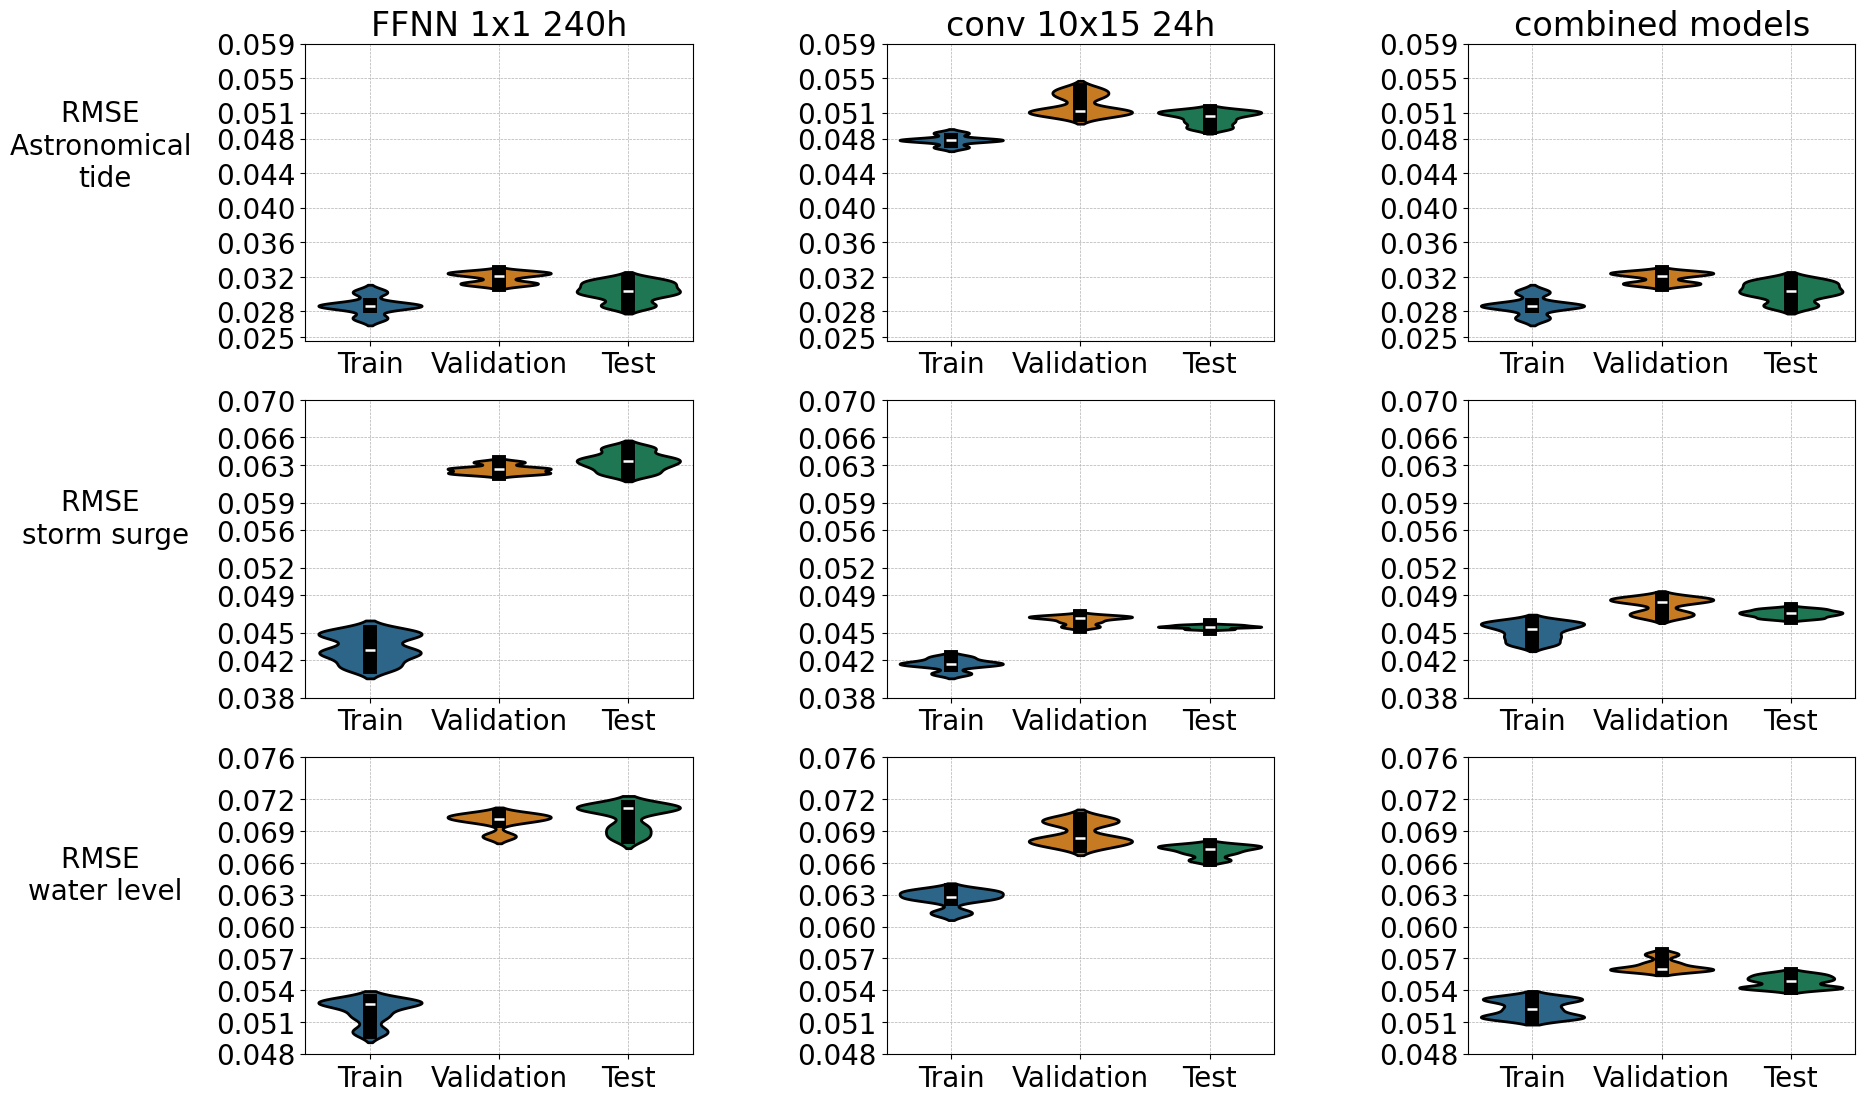

In [246]:
colors = [palette_hex_list[1],palette_hex_list[6], palette_hex_list[3]]

# Crea la figura principale
fig = plt.figure(figsize=(20, 35))

# Crea un layout a griglia principale 3x1
outer_grid = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.5)

# Crea un layout a griglia per il primo subplot principale con 2x3
inner_grid = gridspec.GridSpecFromSubplotSpec(3, len(models_to_analyze), subplot_spec=outer_grid[0], wspace=0.5)

for i in range(0,len(models_to_analyze)):

    train_mae = []
    train_mae.append(train_scores_tide[0][3][i])
    train_mae.append(train_scores_tide[1][3][i])
    train_mae.append(train_scores_tide[2][3][i])
    train_mae.append(train_scores_tide[3][3][i])
    train_mae.append(train_scores_tide[4][3][i])

    val_mae = []
    val_mae.append(val_scores_tide[0][3][i])
    val_mae.append(val_scores_tide[1][3][i])
    val_mae.append(val_scores_tide[2][3][i])
    val_mae.append(val_scores_tide[3][3][i])
    val_mae.append(val_scores_tide[4][3][i])

    test_mae = []
    test_mae.append(test_scores_tide[0][3][i])
    test_mae.append(test_scores_tide[1][3][i])
    test_mae.append(test_scores_tide[2][3][i])
    test_mae.append(test_scores_tide[3][3][i])
    test_mae.append(test_scores_tide[4][3][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[0, i])
    ax.set_ylim((min_mae_tide-(0.1*(max_mae_tide-min_mae_tide)),max_mae_tide+(0.2*(max_mae_tide-min_mae_tide))))
    ax.set_yticks(np.round(np.linspace(min_mae_tide-(0.1*(max_mae_tide-min_mae_tide)), max_mae_tide+(0.2*(max_mae_tide-min_mae_tide)), 10), 3))
    sns.violinplot(
        data=[train_mae, val_mae, test_mae],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)

    if i==0:
        ax.set_title("FFNN 1x1 240h", fontsize=24)
    if i==1:
        ax.set_title("conv 10x15 24h", fontsize=24)
    if i==2:
        ax.set_title("combined models", fontsize=24)

    plt.gca().set_axisbelow(True)  # Mette la griglia sotto i grafici 
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        # ax.set_ylabel("RMSE \ntide only \n "+additional_score, fontsize=20, rotation=0, labelpad=80)
        ax.set_ylabel("RMSE \nAstronomical \ntide", fontsize=20, rotation=0, labelpad=80)
    train_mae = []
    train_mae.append(train_scores_surge[0][3][i])
    train_mae.append(train_scores_surge[1][3][i])
    train_mae.append(train_scores_surge[2][3][i])
    train_mae.append(train_scores_surge[3][3][i])
    train_mae.append(train_scores_surge[4][3][i])

    val_mae = []
    val_mae.append(val_scores_surge[0][3][i])
    val_mae.append(val_scores_surge[1][3][i])
    val_mae.append(val_scores_surge[2][3][i])
    val_mae.append(val_scores_surge[3][3][i])
    val_mae.append(val_scores_surge[4][3][i])

    test_mae = []
    test_mae.append(test_scores_surge[0][3][i])
    test_mae.append(test_scores_surge[1][3][i])
    test_mae.append(test_scores_surge[2][3][i])
    test_mae.append(test_scores_surge[3][3][i])
    test_mae.append(test_scores_surge[4][3][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[1, i])
    ax.set_ylim((min_mae_surge-(0.1*(max_mae_surge-min_mae_surge)),max_mae_surge+(0.2*(max_mae_surge-min_mae_surge))))
    ax.set_yticks(np.round(np.linspace(min_mae_surge-(0.1*(max_mae_surge-min_mae_surge)), max_mae_surge+(0.2*(max_mae_surge-min_mae_surge)), 10),3))
    sns.violinplot(
        data=[train_mae, val_mae, test_mae],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2,  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.gca().set_axisbelow(True)  # Mette la griglia sotto i grafici 
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        # ax.set_ylabel("RMSE \nstorm surge \n "+additional_score, fontsize=20, rotation=0, labelpad=80)
        ax.set_ylabel("RMSE \nstorm surge", fontsize=20, rotation=0, labelpad=80)
    
    train_mae = []
    train_mae.append(train_scores_wl[0][3][i])
    train_mae.append(train_scores_wl[1][3][i])
    train_mae.append(train_scores_wl[2][3][i])
    train_mae.append(train_scores_wl[3][3][i])
    train_mae.append(train_scores_wl[4][3][i])

    val_mae = []
    val_mae.append(val_scores_wl[0][3][i])
    val_mae.append(val_scores_wl[1][3][i])
    val_mae.append(val_scores_wl[2][3][i])
    val_mae.append(val_scores_wl[3][3][i])
    val_mae.append(val_scores_wl[4][3][i])

    test_mae = []
    test_mae.append(test_scores_wl[0][3][i])
    test_mae.append(test_scores_wl[1][3][i])
    test_mae.append(test_scores_wl[2][3][i])
    test_mae.append(test_scores_wl[3][3][i])
    test_mae.append(test_scores_wl[4][3][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[2, i])
    ax.set_ylim((min_mae_wl-(0.1*(max_mae_wl-min_mae_wl)),max_mae_wl+(0.2*(max_mae_wl-min_mae_wl))))
    ax.set_yticks(np.round(np.linspace(min_mae_wl-(0.1*(max_mae_wl-min_mae_wl)), max_mae_wl+(0.2*(max_mae_wl-min_mae_wl)), 10), 3))
    sns.violinplot(
        data=[train_mae, val_mae, test_mae],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        # ax.set_ylabel("RMSE \nwl \n "+additional_score, fontsize=20, rotation=0, labelpad=80)
        ax.set_ylabel("RMSE \nwater level", fontsize=20, rotation=0, labelpad=80)
    plt.gca().set_axisbelow(True)  # Mette la griglia sotto i grafici 
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# Mostra il grafico
# plt.tight_layout()

# plt.show()
# plt.savefig("img_paper/RMSE_best_models.pdf", format="pdf", bbox_inches="tight", dpi=400)
plt.show()

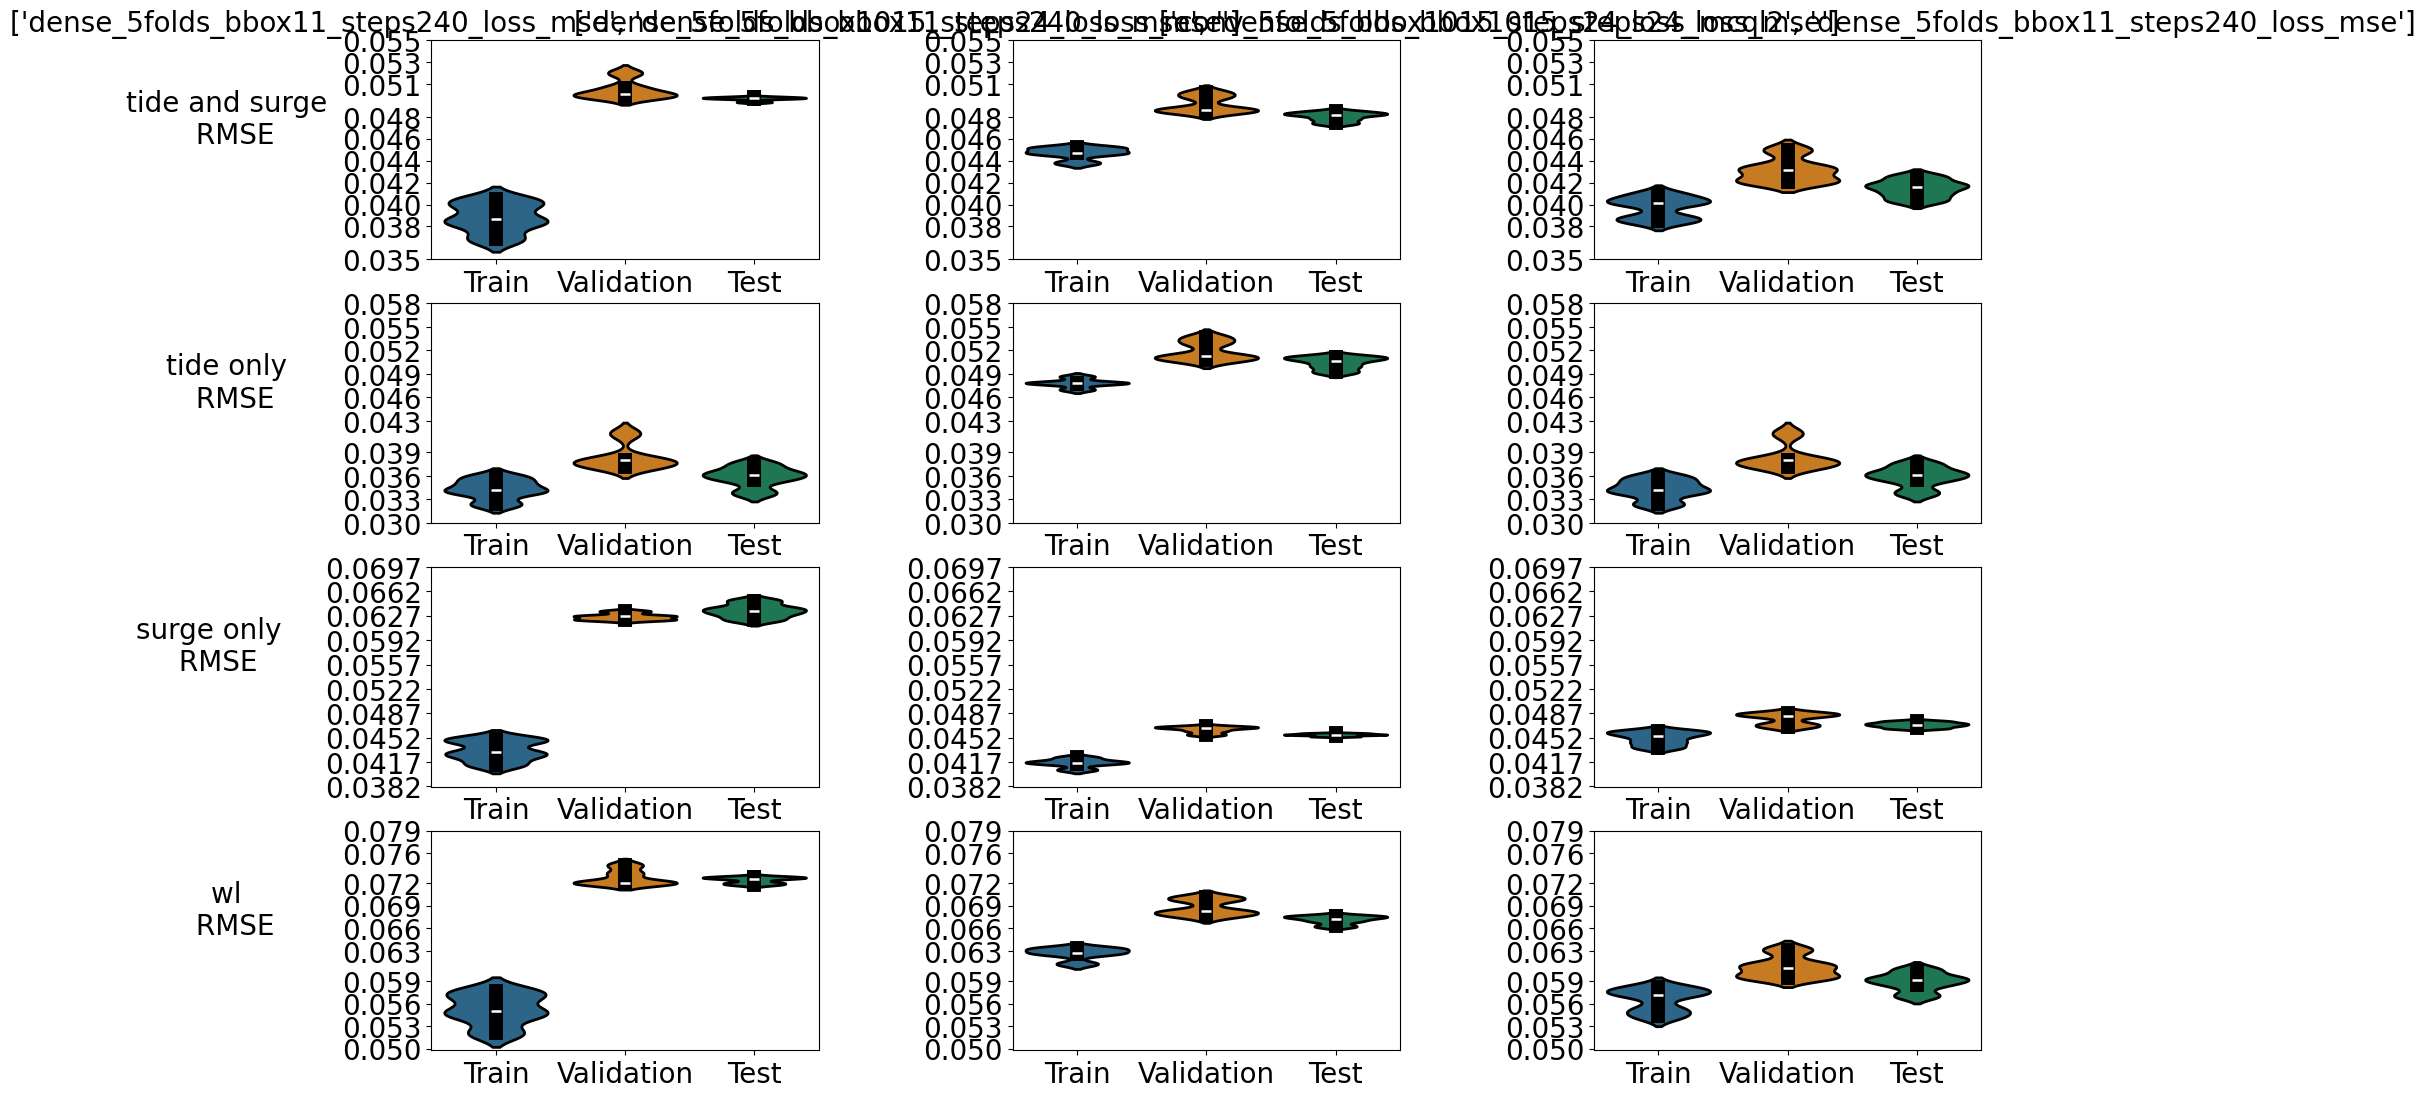

In [217]:
colors = [palette_hex_list[1],palette_hex_list[6], palette_hex_list[3]]

# Crea la figura principale
fig = plt.figure(figsize=(20, 35))

# Crea un layout a griglia principale 3x1
outer_grid = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.5)

# Crea un layout a griglia per il primo subplot principale con 2x3
inner_grid = gridspec.GridSpecFromSubplotSpec(4, len(models_to_analyze), subplot_spec=outer_grid[0], wspace=0.5)

for i in range(0,len(models_to_analyze)):

    train_mae = []
    train_mae.append(train_scores[0][3][i])
    train_mae.append(train_scores[1][3][i])
    train_mae.append(train_scores[2][3][i])
    train_mae.append(train_scores[3][3][i])
    train_mae.append(train_scores[4][3][i])

    val_mae = []
    val_mae.append(val_scores[0][3][i])
    val_mae.append(val_scores[1][3][i])
    val_mae.append(val_scores[2][3][i])
    val_mae.append(val_scores[3][3][i])
    val_mae.append(val_scores[4][3][i])

    test_mae = []
    test_mae.append(test_scores[0][3][i])
    test_mae.append(test_scores[1][3][i])
    test_mae.append(test_scores[2][3][i])
    test_mae.append(test_scores[3][3][i])
    test_mae.append(test_scores[4][3][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[0, i])
    ax.set_ylim((min_mae-(0.1*(max_mae-min_mae)),max_mae+(0.2*(max_mae-min_mae))))
    ax.set_yticks(np.round(np.linspace(min_mae-(0.1*(max_mae-min_mae)), max_mae+(0.2*(max_mae-min_mae)), 10), 3))
    sns.violinplot(
        data=[train_mae, val_mae, test_mae],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(models_to_analyze[i], fontsize=20)
    if i == 0:
        ax.set_ylabel("tide and surge \n "+additional_score, fontsize=20, rotation=0, labelpad=80)

    train_mae = []
    train_mae.append(train_scores_tide[0][3][i])
    train_mae.append(train_scores_tide[1][3][i])
    train_mae.append(train_scores_tide[2][3][i])
    train_mae.append(train_scores_tide[3][3][i])
    train_mae.append(train_scores_tide[4][3][i])

    val_mae = []
    val_mae.append(val_scores_tide[0][3][i])
    val_mae.append(val_scores_tide[1][3][i])
    val_mae.append(val_scores_tide[2][3][i])
    val_mae.append(val_scores_tide[3][3][i])
    val_mae.append(val_scores_tide[4][3][i])

    test_mae = []
    test_mae.append(test_scores_tide[0][3][i])
    test_mae.append(test_scores_tide[1][3][i])
    test_mae.append(test_scores_tide[2][3][i])
    test_mae.append(test_scores_tide[3][3][i])
    test_mae.append(test_scores_tide[4][3][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[1, i])
    ax.set_ylim((min_mae_tide-(0.1*(max_mae_tide-min_mae_tide)),max_mae_tide+(0.2*(max_mae_tide-min_mae_tide))))
    ax.set_yticks(np.round(np.linspace(min_mae_tide-(0.1*(max_mae_tide-min_mae_tide)), max_mae_tide+(0.2*(max_mae_tide-min_mae_tide)), 10), 3))
    sns.violinplot(
        data=[train_mae, val_mae, test_mae],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        ax.set_ylabel("tide only \n "+additional_score, fontsize=20, rotation=0, labelpad=80)

    train_mae = []
    train_mae.append(train_scores_surge[0][3][i])
    train_mae.append(train_scores_surge[1][3][i])
    train_mae.append(train_scores_surge[2][3][i])
    train_mae.append(train_scores_surge[3][3][i])
    train_mae.append(train_scores_surge[4][3][i])

    val_mae = []
    val_mae.append(val_scores_surge[0][3][i])
    val_mae.append(val_scores_surge[1][3][i])
    val_mae.append(val_scores_surge[2][3][i])
    val_mae.append(val_scores_surge[3][3][i])
    val_mae.append(val_scores_surge[4][3][i])

    test_mae = []
    test_mae.append(test_scores_surge[0][3][i])
    test_mae.append(test_scores_surge[1][3][i])
    test_mae.append(test_scores_surge[2][3][i])
    test_mae.append(test_scores_surge[3][3][i])
    test_mae.append(test_scores_surge[4][3][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[2, i])
    ax.set_ylim((min_mae_surge-(0.1*(max_mae_surge-min_mae_surge)),max_mae_surge+(0.2*(max_mae_surge-min_mae_surge))))
    ax.set_yticks(np.round(np.linspace(min_mae_surge-(0.1*(max_mae_surge-min_mae_surge)), max_mae_surge+(0.2*(max_mae_surge-min_mae_surge)), 10),4))
    sns.violinplot(
        data=[train_mae, val_mae, test_mae],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2,  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        ax.set_ylabel("surge only \n "+additional_score, fontsize=20, rotation=0, labelpad=80)

    train_mae = []
    train_mae.append(train_scores_wl[0][3][i])
    train_mae.append(train_scores_wl[1][3][i])
    train_mae.append(train_scores_wl[2][3][i])
    train_mae.append(train_scores_wl[3][3][i])
    train_mae.append(train_scores_wl[4][3][i])

    val_mae = []
    val_mae.append(val_scores_wl[0][3][i])
    val_mae.append(val_scores_wl[1][3][i])
    val_mae.append(val_scores_wl[2][3][i])
    val_mae.append(val_scores_wl[3][3][i])
    val_mae.append(val_scores_wl[4][3][i])

    test_mae = []
    test_mae.append(test_scores_wl[0][3][i])
    test_mae.append(test_scores_wl[1][3][i])
    test_mae.append(test_scores_wl[2][3][i])
    test_mae.append(test_scores_wl[3][3][i])
    test_mae.append(test_scores_wl[4][3][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[3, i])
    ax.set_ylim((min_mae_wl-(0.1*(max_mae_wl-min_mae_wl)),max_mae_wl+(0.2*(max_mae_wl-min_mae_wl))))
    ax.set_yticks(np.round(np.linspace(min_mae_wl-(0.1*(max_mae_wl-min_mae_wl)), max_mae_wl+(0.2*(max_mae_wl-min_mae_wl)), 10), 3))
    sns.violinplot(
        data=[train_mae, val_mae, test_mae],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        ax.set_ylabel("wl \n "+additional_score, fontsize=20, rotation=0, labelpad=80)

# Mostra il grafico
# plt.tight_layout()
plt.show()

In [218]:
min_mse=999
max_mse=0
min_mse_tide=999
max_mse_tide=0
min_mse_surge=999
max_mse_surge=0
min_mse_wl=999
max_mse_wl=0
for i in range(0,len(models_to_analyze)):

    train_mse = []
    train_mse.append(train_scores[0][0][i])
    train_mse.append(train_scores[1][0][i])
    train_mse.append(train_scores[2][0][i])
    train_mse.append(train_scores[3][0][i])
    train_mse.append(train_scores[4][0][i])
    val_mse = []
    val_mse.append(val_scores[0][0][i])
    val_mse.append(val_scores[1][0][i])
    val_mse.append(val_scores[2][0][i])
    val_mse.append(val_scores[3][0][i])
    val_mse.append(val_scores[4][0][i])
    test_mse = []
    test_mse.append(test_scores[0][0][i])
    test_mse.append(test_scores[1][0][i])
    test_mse.append(test_scores[2][0][i])
    test_mse.append(test_scores[3][0][i])
    test_mse.append(test_scores[4][0][i])

    min_train_mse = min(train_mse)
    max_train_mse = max(train_mse)

    min_val_mse = min(val_mse)
    max_val_mse = max(val_mse)

    min_test_mse = min(test_mse)
    max_test_mse = max(test_mse)
    
    iter_min_mse = min([min_train_mse,min_val_mse,min_test_mse])
    iter_max_mse = max([max_train_mse,max_val_mse,max_test_mse])
    
    min_mse = min([min_mse,iter_min_mse])
    max_mse = max([max_mse,iter_max_mse])

    train_mse_tide = []
    train_mse_tide.append(train_scores_tide[0][0][i])
    train_mse_tide.append(train_scores_tide[1][0][i])
    train_mse_tide.append(train_scores_tide[2][0][i])
    train_mse_tide.append(train_scores_tide[3][0][i])
    train_mse_tide.append(train_scores_tide[4][0][i])
    val_mse_tide = []
    val_mse_tide.append(val_scores_tide[0][0][i])
    val_mse_tide.append(val_scores_tide[1][0][i])
    val_mse_tide.append(val_scores_tide[2][0][i])
    val_mse_tide.append(val_scores_tide[3][0][i])
    val_mse_tide.append(val_scores_tide[4][0][i])
    test_mse_tide = []
    test_mse_tide.append(test_scores_tide[0][0][i])
    test_mse_tide.append(test_scores_tide[1][0][i])
    test_mse_tide.append(test_scores_tide[2][0][i])
    test_mse_tide.append(test_scores_tide[3][0][i])
    test_mse_tide.append(test_scores_tide[4][0][i])

    min_train_mse_tide = min(train_mse_tide)
    max_train_mse_tide = max(train_mse_tide)

    min_val_mse_tide= min(val_mse_tide)
    max_val_mse_tide = max(val_mse_tide)

    min_test_mse_tide = min(test_mse_tide)
    max_test_mse_tide = max(test_mse_tide)
    
    iter_min_mse_tide = min([min_train_mse_tide,min_val_mse_tide,min_test_mse_tide])
    iter_max_mse_tide = max([max_train_mse_tide,max_val_mse_tide,max_test_mse_tide])
    
    min_mse_tide = min([min_mse_tide,iter_min_mse_tide])
    max_mse_tide = max([max_mse_tide,iter_max_mse_tide])

    train_mse_surge = []
    train_mse_surge.append(train_scores_surge[0][0][i])
    train_mse_surge.append(train_scores_surge[1][0][i])
    train_mse_surge.append(train_scores_surge[2][0][i])
    train_mse_surge.append(train_scores_surge[3][0][i])
    train_mse_surge.append(train_scores_surge[4][0][i])
    val_mse_surge = []
    val_mse_surge.append(val_scores_surge[0][0][i])
    val_mse_surge.append(val_scores_surge[1][0][i])
    val_mse_surge.append(val_scores_surge[2][0][i])
    val_mse_surge.append(val_scores_surge[3][0][i])
    val_mse_surge.append(val_scores_surge[4][0][i])
    test_mse_surge = []
    test_mse_surge.append(test_scores_surge[0][0][i])
    test_mse_surge.append(test_scores_surge[1][0][i])
    test_mse_surge.append(test_scores_surge[2][0][i])
    test_mse_surge.append(test_scores_surge[3][0][i])
    test_mse_surge.append(test_scores_surge[4][0][i])

    min_train_mse_surge = min(train_mse_surge)
    max_train_mse_surge = max(train_mse_surge)

    min_val_mse_surge = min(val_mse_surge)
    max_val_mse_surge = max(val_mse_surge)

    min_test_mse_surge = min(test_mse_surge)
    max_test_mse_surge = max(test_mse_surge)
    
    iter_min_mse_surge = min([min_train_mse_surge,min_val_mse_surge,min_test_mse_surge])
    iter_max_mse_surge = max([max_train_mse_surge,max_val_mse_surge,max_test_mse_surge])
    
    min_mse_surge = min([min_mse_surge,iter_min_mse_surge])
    max_mse_surge = max([max_mse_surge,iter_max_mse_surge])

    train_mse_wl = []
    train_mse_wl.append(train_scores_wl[0][0][i])
    train_mse_wl.append(train_scores_wl[1][0][i])
    train_mse_wl.append(train_scores_wl[2][0][i])
    train_mse_wl.append(train_scores_wl[3][0][i])
    train_mse_wl.append(train_scores_wl[4][0][i])
    val_mse_wl = []
    val_mse_wl.append(val_scores_wl[0][0][i])
    val_mse_wl.append(val_scores_wl[1][0][i])
    val_mse_wl.append(val_scores_wl[2][0][i])
    val_mse_wl.append(val_scores_wl[3][0][i])
    val_mse_wl.append(val_scores_wl[4][0][i])
    test_mse_wl = []
    test_mse_wl.append(test_scores_wl[0][0][i])
    test_mse_wl.append(test_scores_wl[1][0][i])
    test_mse_wl.append(test_scores_wl[2][0][i])
    test_mse_wl.append(test_scores_wl[3][0][i])
    test_mse_wl.append(test_scores_wl[4][0][i])

    min_train_mse_wl = min(train_mse_wl)
    max_train_mse_wl = max(train_mse_wl)

    min_val_mse_wl = min(val_mse_wl)
    max_val_mse_wl = max(val_mse_wl)

    min_test_mse_wl = min(test_mse_wl)
    max_test_mse_wl = max(test_mse_wl)

    iter_min_mse_wl = min([min_train_mse_wl,min_val_mse_wl,min_test_mse_wl])
    iter_max_mse_wl = max([max_train_mse_wl,max_val_mse_wl,max_test_mse_wl])

    min_mse_wl = min([min_mse_wl,iter_min_mse_wl])
    max_mse_wl = max([max_mse_wl,iter_max_mse_wl])

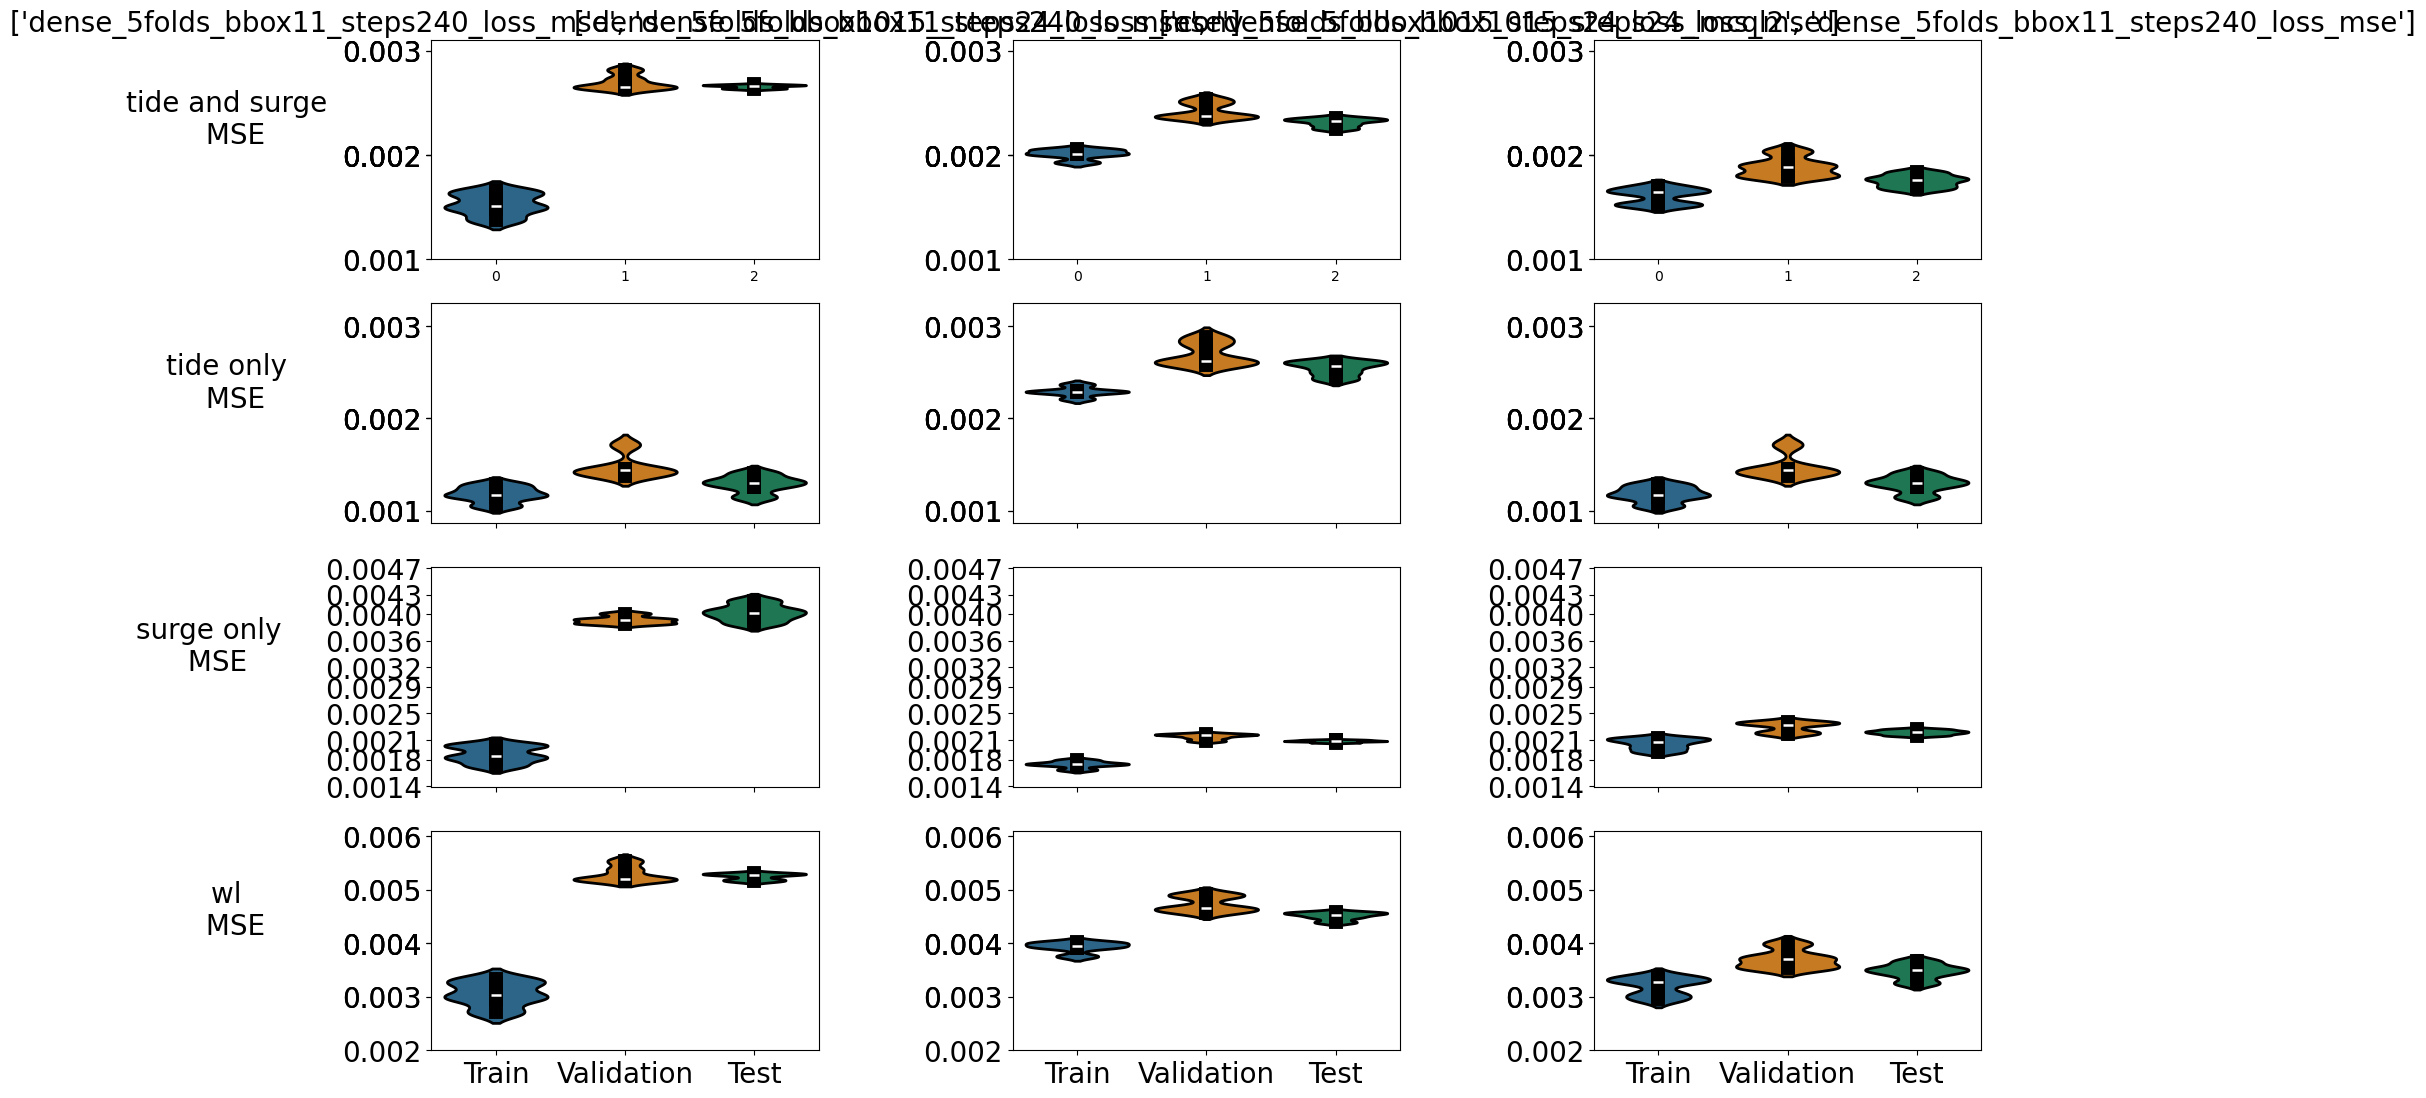

In [219]:
colors = [palette_hex_list[1],palette_hex_list[6], palette_hex_list[3]]

# Crea la figura principale
fig = plt.figure(figsize=(20, 35))

# Crea un layout a griglia principale 3x1
outer_grid = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.5)

# Crea un layout a griglia per il primo subplot principale con 2x3
inner_grid = gridspec.GridSpecFromSubplotSpec(4, len(models_to_analyze), subplot_spec=outer_grid[0], wspace=0.5)

for i in range(0,len(models_to_analyze)):

    train_mse = []
    train_mse.append(train_scores[0][0][i])
    train_mse.append(train_scores[1][0][i])
    train_mse.append(train_scores[2][0][i])
    train_mse.append(train_scores[3][0][i])
    train_mse.append(train_scores[4][0][i])

    val_mse = []
    val_mse.append(val_scores[0][0][i])
    val_mse.append(val_scores[1][0][i])
    val_mse.append(val_scores[2][0][i])
    val_mse.append(val_scores[3][0][i])
    val_mse.append(val_scores[4][0][i])

    test_mse = []
    test_mse.append(test_scores[0][0][i])
    test_mse.append(test_scores[1][0][i])
    test_mse.append(test_scores[2][0][i])
    test_mse.append(test_scores[3][0][i])
    test_mse.append(test_scores[4][0][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[0, i])
    ax.set_ylim((min_mse-(0.1*(max_mse-min_mse)),max_mse+(0.2*(max_mse-min_mse))))
    ax.set_yticks(np.round(np.linspace(min_mse-(0.1*(max_mse-min_mse)), max_mse+(0.2*(max_mse-min_mse)), 10), 3))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    # ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(models_to_analyze[i], fontsize=20)
    if i == 0:
        ax.set_ylabel("tide and surge \n MSE", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_tide[0][0][i])
    train_mse.append(train_scores_tide[1][0][i])
    train_mse.append(train_scores_tide[2][0][i])
    train_mse.append(train_scores_tide[3][0][i])
    train_mse.append(train_scores_tide[4][0][i])

    val_mse = []
    val_mse.append(val_scores_tide[0][0][i])
    val_mse.append(val_scores_tide[1][0][i])
    val_mse.append(val_scores_tide[2][0][i])
    val_mse.append(val_scores_tide[3][0][i])
    val_mse.append(val_scores_tide[4][0][i])

    test_mse = []
    test_mse.append(test_scores_tide[0][0][i])
    test_mse.append(test_scores_tide[1][0][i])
    test_mse.append(test_scores_tide[2][0][i])
    test_mse.append(test_scores_tide[3][0][i])
    test_mse.append(test_scores_tide[4][0][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[1, i])
    ax.set_ylim((min_mse_tide-(0.1*(max_mse_tide-min_mse_tide)),max_mse_tide+(0.2*(max_mse_tide-min_mse_tide))))
    ax.set_yticks(np.round(np.linspace(min_mse_tide-(0.1*(max_mse_tide-min_mse_tide)), max_mse_tide+(0.2*(max_mse_tide-min_mse_tide)), 10), 3))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    # ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.set_xticks([0, 1, 2], ['', '', ''], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        ax.set_ylabel("tide only \n MSE", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_surge[0][0][i])
    train_mse.append(train_scores_surge[1][0][i])
    train_mse.append(train_scores_surge[2][0][i])
    train_mse.append(train_scores_surge[3][0][i])
    train_mse.append(train_scores_surge[4][0][i])

    val_mse = []
    val_mse.append(val_scores_surge[0][0][i])
    val_mse.append(val_scores_surge[1][0][i])
    val_mse.append(val_scores_surge[2][0][i])
    val_mse.append(val_scores_surge[3][0][i])
    val_mse.append(val_scores_surge[4][0][i])

    test_mse = []
    test_mse.append(test_scores_surge[0][0][i])
    test_mse.append(test_scores_surge[1][0][i])
    test_mse.append(test_scores_surge[2][0][i])
    test_mse.append(test_scores_surge[3][0][i])
    test_mse.append(test_scores_surge[4][0][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[2, i])
    ax.set_ylim((min_mse_surge-(0.1*(max_mse_surge-min_mse_surge)),max_mse_surge+(0.2*(max_mse_surge-min_mse_surge))))
    ax.set_yticks(np.round(np.linspace(min_mse_surge-(0.1*(max_mse_surge-min_mse_surge)), max_mse_surge+(0.2*(max_mse_surge-min_mse_surge)), 10),4))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2,  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    # ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.set_xticks([0, 1, 2], ['', '', ''], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        ax.set_ylabel("surge only \n MSE", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_wl[0][0][i])
    train_mse.append(train_scores_wl[1][0][i])
    train_mse.append(train_scores_wl[2][0][i])
    train_mse.append(train_scores_wl[3][0][i])
    train_mse.append(train_scores_wl[4][0][i])

    val_mse = []
    val_mse.append(val_scores_wl[0][0][i])
    val_mse.append(val_scores_wl[1][0][i])
    val_mse.append(val_scores_wl[2][0][i])
    val_mse.append(val_scores_wl[3][0][i])
    val_mse.append(val_scores_wl[4][0][i])

    test_mse = []
    test_mse.append(test_scores_wl[0][0][i])
    test_mse.append(test_scores_wl[1][0][i])
    test_mse.append(test_scores_wl[2][0][i])
    test_mse.append(test_scores_wl[3][0][i])
    test_mse.append(test_scores_wl[4][0][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[3, i])
    ax.set_ylim((min_mse_wl-(0.1*(max_mse_wl-min_mse_wl)),max_mse_wl+(0.2*(max_mse_wl-min_mse_wl))))
    ax.set_yticks(np.round(np.linspace(min_mse_wl-(0.1*(max_mse_wl-min_mse_wl)), max_mse_wl+(0.2*(max_mse_wl-min_mse_wl)), 10), 3))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    # ax.set_title(models_to_analyze[i])
    if i == 0:
        ax.set_ylabel("wl \n MSE", fontsize=20, rotation=0, labelpad=80)

# Mostra il grafico
# plt.tight_layout()
plt.show()

In [220]:
min_qloss=999
max_qloss=0
min_qloss_tide=999
max_qloss_tide=0
min_qloss_surge=999
max_qloss_surge=0
min_qloss_wl=999
max_qloss_wl=0
for i in range(0,len(models_to_analyze)):

    train_qloss = []
    train_qloss.append(train_scores[0][1][i])
    train_qloss.append(train_scores[1][1][i])
    train_qloss.append(train_scores[2][1][i])
    train_qloss.append(train_scores[3][1][i])
    train_qloss.append(train_scores[4][1][i])
    val_qloss = []
    val_qloss.append(val_scores[0][1][i])
    val_qloss.append(val_scores[1][1][i])
    val_qloss.append(val_scores[2][1][i])
    val_qloss.append(val_scores[3][1][i])
    val_qloss.append(val_scores[4][1][i])
    test_qloss = []
    test_qloss.append(test_scores[0][1][i])
    test_qloss.append(test_scores[1][1][i])
    test_qloss.append(test_scores[2][1][i])
    test_qloss.append(test_scores[3][1][i])
    test_qloss.append(test_scores[4][1][i])

    min_train_qloss = min(train_qloss)
    max_train_qloss = max(train_qloss)

    min_val_qloss = min(val_qloss)
    max_val_qloss = max(val_qloss)

    min_test_qloss = min(test_qloss)
    max_test_qloss = max(test_qloss)
    
    iter_min_qloss = min([min_train_qloss,min_val_qloss,min_test_qloss])
    iter_max_qloss = max([max_train_qloss,max_val_qloss,max_test_qloss])
    
    min_qloss = min([min_qloss,iter_min_qloss])
    max_qloss = max([max_qloss,iter_max_qloss])

    train_qloss_tide = []
    train_qloss_tide.append(train_scores_tide[0][1][i])
    train_qloss_tide.append(train_scores_tide[1][1][i])
    train_qloss_tide.append(train_scores_tide[2][1][i])
    train_qloss_tide.append(train_scores_tide[3][1][i])
    train_qloss_tide.append(train_scores_tide[4][1][i])
    val_qloss_tide = []
    val_qloss_tide.append(val_scores_tide[0][1][i])
    val_qloss_tide.append(val_scores_tide[1][1][i])
    val_qloss_tide.append(val_scores_tide[2][1][i])
    val_qloss_tide.append(val_scores_tide[3][1][i])
    val_qloss_tide.append(val_scores_tide[4][1][i])
    test_qloss_tide = []
    test_qloss_tide.append(test_scores_tide[0][1][i])
    test_qloss_tide.append(test_scores_tide[1][1][i])
    test_qloss_tide.append(test_scores_tide[2][1][i])
    test_qloss_tide.append(test_scores_tide[3][1][i])
    test_qloss_tide.append(test_scores_tide[4][1][i])

    min_train_qloss_tide = min(train_qloss_tide)
    max_train_qloss_tide = max(train_qloss_tide)

    min_val_qloss_tide= min(val_qloss_tide)
    max_val_qloss_tide = max(val_qloss_tide)

    min_test_qloss_tide = min(test_qloss_tide)
    max_test_qloss_tide = max(test_qloss_tide)
    
    iter_min_qloss_tide = min([min_train_qloss_tide,min_val_qloss_tide,min_test_qloss_tide])
    iter_max_qloss_tide = max([max_train_qloss_tide,max_val_qloss_tide,max_test_qloss_tide])
    
    min_qloss_tide = min([min_qloss_tide,iter_min_qloss_tide])
    max_qloss_tide = max([max_qloss_tide,iter_max_qloss_tide])

    train_qloss_surge = []
    train_qloss_surge.append(train_scores_surge[0][1][i])
    train_qloss_surge.append(train_scores_surge[1][1][i])
    train_qloss_surge.append(train_scores_surge[2][1][i])
    train_qloss_surge.append(train_scores_surge[3][1][i])
    train_qloss_surge.append(train_scores_surge[4][1][i])
    val_qloss_surge = []
    val_qloss_surge.append(val_scores_surge[0][1][i])
    val_qloss_surge.append(val_scores_surge[1][1][i])
    val_qloss_surge.append(val_scores_surge[2][1][i])
    val_qloss_surge.append(val_scores_surge[3][1][i])
    val_qloss_surge.append(val_scores_surge[4][1][i])
    test_qloss_surge = []
    test_qloss_surge.append(test_scores_surge[0][1][i])
    test_qloss_surge.append(test_scores_surge[1][1][i])
    test_qloss_surge.append(test_scores_surge[2][1][i])
    test_qloss_surge.append(test_scores_surge[3][1][i])
    test_qloss_surge.append(test_scores_surge[4][1][i])

    min_train_qloss_surge = min(train_qloss_surge)
    max_train_qloss_surge = max(train_qloss_surge)

    min_val_qloss_surge = min(val_qloss_surge)
    max_val_qloss_surge = max(val_qloss_surge)

    min_test_qloss_surge = min(test_qloss_surge)
    max_test_qloss_surge = max(test_qloss_surge)
    
    iter_min_qloss_surge = min([min_train_qloss_surge,min_val_qloss_surge,min_test_qloss_surge])
    iter_max_qloss_surge = max([max_train_qloss_surge,max_val_qloss_surge,max_test_qloss_surge])
    
    min_qloss_surge = min([min_qloss_surge,iter_min_qloss_surge])
    max_qloss_surge = max([max_qloss_surge,iter_max_qloss_surge])

    train_qloss_wl = []
    train_qloss_wl.append(train_scores_wl[0][1][i])
    train_qloss_wl.append(train_scores_wl[1][1][i])
    train_qloss_wl.append(train_scores_wl[2][1][i])
    train_qloss_wl.append(train_scores_wl[3][1][i])
    train_qloss_wl.append(train_scores_wl[4][1][i])
    val_qloss_wl = []
    val_qloss_wl.append(val_scores_wl[0][1][i])
    val_qloss_wl.append(val_scores_wl[1][1][i])
    val_qloss_wl.append(val_scores_wl[2][1][i])
    val_qloss_wl.append(val_scores_wl[3][1][i])
    val_qloss_wl.append(val_scores_wl[4][1][i])
    test_qloss_wl = []
    test_qloss_wl.append(test_scores_wl[0][1][i])
    test_qloss_wl.append(test_scores_wl[1][1][i])
    test_qloss_wl.append(test_scores_wl[2][1][i])
    test_qloss_wl.append(test_scores_wl[3][1][i])
    test_qloss_wl.append(test_scores_wl[4][1][i])

    min_train_qloss_wl = min(train_qloss_wl)
    max_train_qloss_wl = max(train_qloss_wl)

    min_val_qloss_wl = min(val_qloss_wl)
    max_val_qloss_wl = max(val_qloss_wl)

    min_test_qloss_wl = min(test_qloss_wl)
    max_test_qloss_wl = max(test_qloss_wl)
    
    iter_min_qloss_wl = min([min_train_qloss_wl,min_val_qloss_wl,min_test_qloss_wl])
    iter_max_qloss_wl = max([max_train_qloss_wl,max_val_qloss_wl,max_test_qloss_wl])
    
    min_qloss_wl = min([min_qloss_wl,iter_min_qloss_wl])
    max_qloss_wl = max([max_qloss_wl,iter_max_qloss_wl])

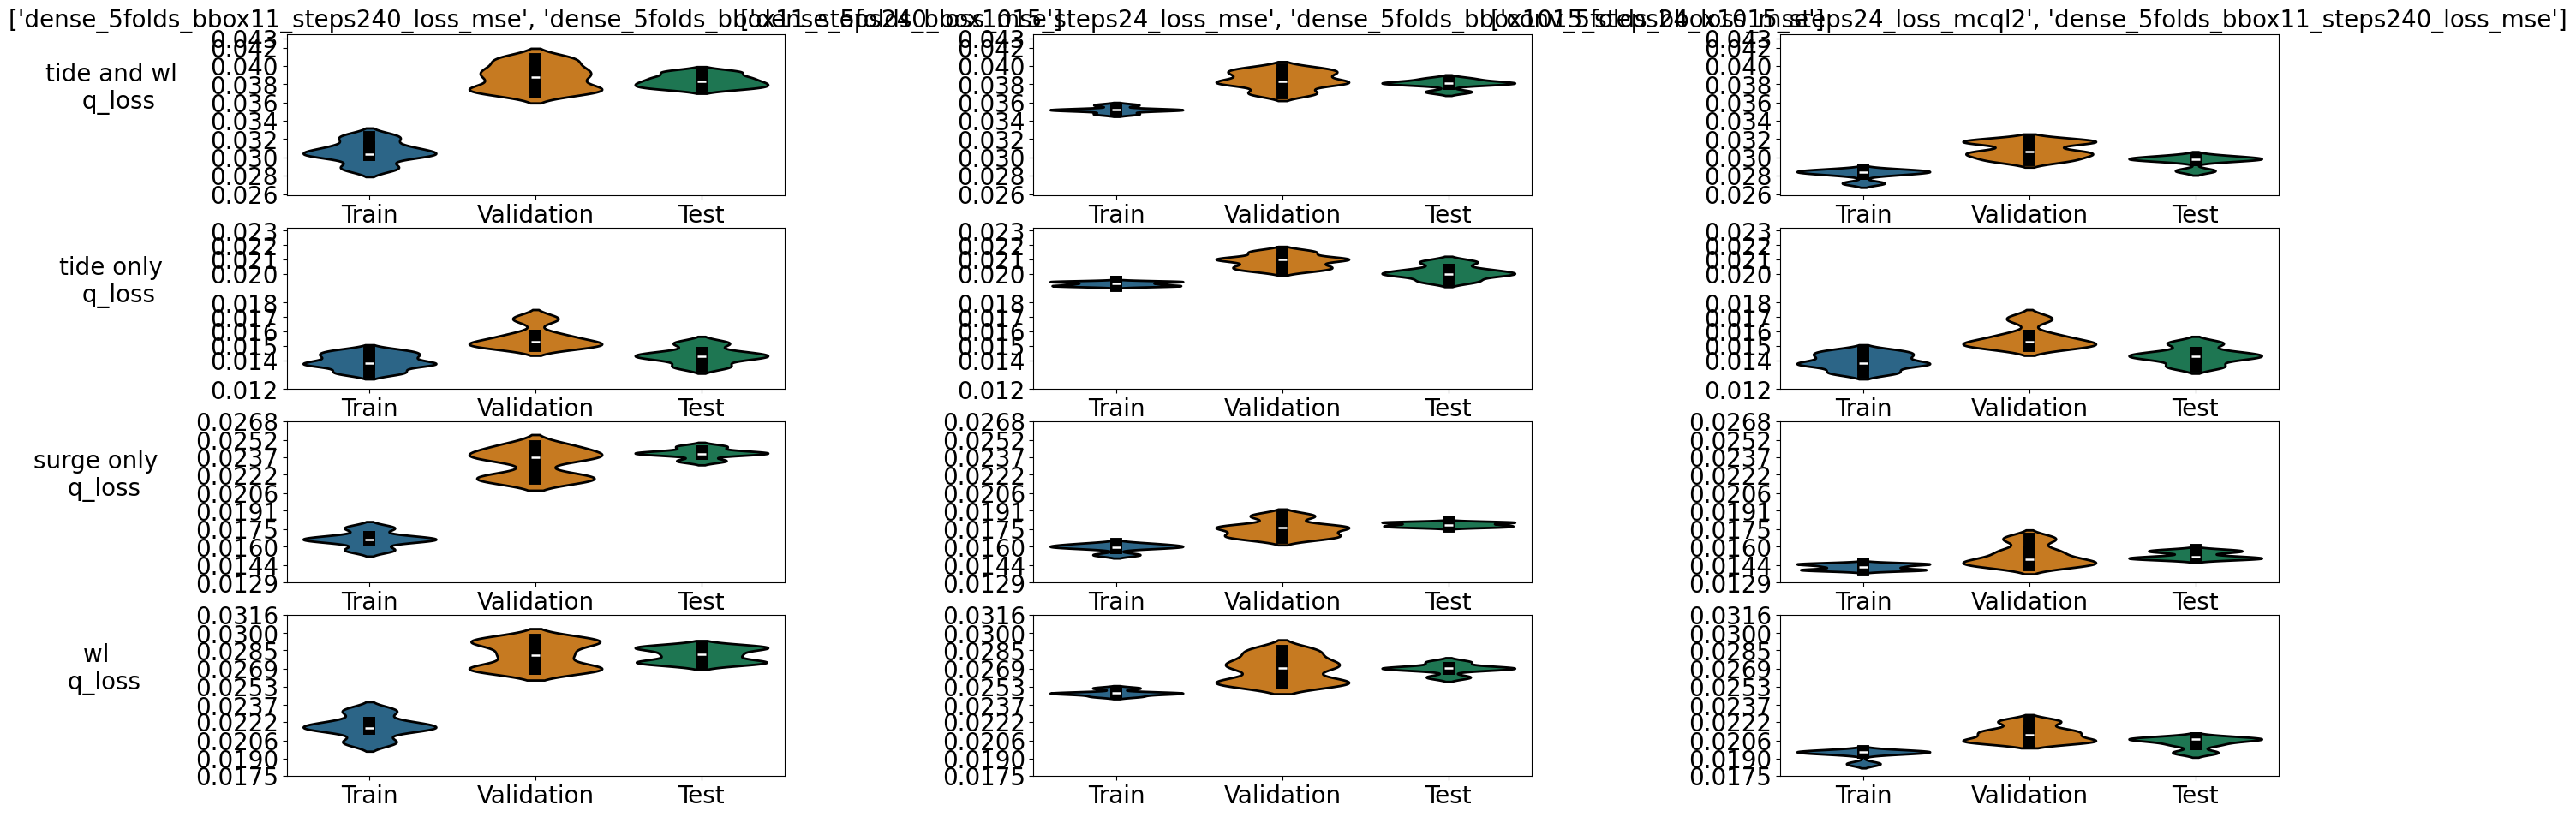

In [221]:

colors = [palette_hex_list[1],palette_hex_list[6], palette_hex_list[3]]

# Crea la figura principale
fig = plt.figure(figsize=(30, 30))

# Crea un layout a griglia principale 3x1
outer_grid = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.5)

# Crea un layout a griglia per il primo subplot principale con 2x3
inner_grid = gridspec.GridSpecFromSubplotSpec(4, len(models_to_analyze), subplot_spec=outer_grid[0], wspace=0.5)

for i in range(0,len(models_to_analyze)):

    train_mse = []
    train_mse.append(train_scores[0][1][i])
    train_mse.append(train_scores[1][1][i])
    train_mse.append(train_scores[2][1][i])
    train_mse.append(train_scores[3][1][i])
    train_mse.append(train_scores[4][1][i])

    val_mse = []
    val_mse.append(val_scores[0][1][i])
    val_mse.append(val_scores[1][1][i])
    val_mse.append(val_scores[2][1][i])
    val_mse.append(val_scores[3][1][i])
    val_mse.append(val_scores[4][1][i])

    test_mse = []
    test_mse.append(test_scores[0][1][i])
    test_mse.append(test_scores[1][1][i])
    test_mse.append(test_scores[2][1][i])
    test_mse.append(test_scores[3][1][i])
    test_mse.append(test_scores[4][1][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[0, i])
    ax.set_ylim((min_qloss-(0.1*(max_qloss-min_qloss)),max_qloss+(0.2*(max_qloss-min_qloss))))
    ax.set_yticks(np.round(np.linspace(min_qloss-(0.1*(max_qloss-min_qloss)), max_qloss+(0.2*(max_qloss-min_qloss)), 10),3))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(models_to_analyze[i], fontsize=20)
    if i == 0:
        ax.set_ylabel("tide and wl \n q_loss", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_tide[0][1][i])
    train_mse.append(train_scores_tide[1][1][i])
    train_mse.append(train_scores_tide[2][1][i])
    train_mse.append(train_scores_tide[3][1][i])
    train_mse.append(train_scores_tide[4][1][i])

    val_mse = []
    val_mse.append(val_scores_tide[0][1][i])
    val_mse.append(val_scores_tide[1][1][i])
    val_mse.append(val_scores_tide[2][1][i])
    val_mse.append(val_scores_tide[3][1][i])
    val_mse.append(val_scores_tide[4][1][i])

    test_mse = []
    test_mse.append(test_scores_tide[0][1][i])
    test_mse.append(test_scores_tide[1][1][i])
    test_mse.append(test_scores_tide[2][1][i])
    test_mse.append(test_scores_tide[3][1][i])
    test_mse.append(test_scores_tide[4][1][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[1, i])
    ax.set_ylim((min_qloss_tide-(0.1*(max_qloss_tide-min_qloss)),max_qloss_tide+(0.2*(max_qloss_tide-min_qloss_tide))))
    ax.set_yticks(np.round(np.linspace(min_qloss_tide-(0.1*(max_qloss_tide-min_qloss_tide)), max_qloss_tide+(0.2*(max_qloss_tide-min_qloss_tide)), 10),3))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if i == 0:
        ax.set_ylabel("tide only \n q_loss", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_surge[0][1][i])
    train_mse.append(train_scores_surge[1][1][i])
    train_mse.append(train_scores_surge[2][1][i])
    train_mse.append(train_scores_surge[3][1][i])
    train_mse.append(train_scores_surge[4][1][i])

    val_mse = []
    val_mse.append(val_scores_surge[0][1][i])
    val_mse.append(val_scores_surge[1][1][i])
    val_mse.append(val_scores_surge[2][1][i])
    val_mse.append(val_scores_surge[3][1][i])
    val_mse.append(val_scores_surge[4][1][i])

    test_mse = []
    test_mse.append(test_scores_surge[0][1][i])
    test_mse.append(test_scores_surge[1][1][i])
    test_mse.append(test_scores_surge[2][1][i])
    test_mse.append(test_scores_surge[3][1][i])
    test_mse.append(test_scores_surge[4][1][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[2, i])
    ax.set_ylim((min_qloss_surge-(0.1*(max_qloss_surge-min_qloss_surge)),max_qloss_surge+(0.2*(max_qloss_surge-min_qloss_surge))))
    ax.set_yticks(np.round(np.linspace(min_qloss_surge-(0.1*(max_qloss_surge-min_qloss_surge)), max_qloss_surge+(0.2*(max_qloss_surge-min_qloss_surge)), 10),4))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    palette=colors,
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if i == 0:
        ax.set_ylabel("surge only \n q_loss", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_wl[0][1][i])
    train_mse.append(train_scores_wl[1][1][i])
    train_mse.append(train_scores_wl[2][1][i])
    train_mse.append(train_scores_wl[3][1][i])
    train_mse.append(train_scores_wl[4][1][i])

    val_mse = []
    val_mse.append(val_scores_wl[0][1][i])
    val_mse.append(val_scores_wl[0][1][i])
    val_mse.append(val_scores_wl[2][1][i])
    val_mse.append(val_scores_wl[3][1][i])
    val_mse.append(val_scores_wl[4][1][i])

    test_mse = []
    test_mse.append(test_scores_wl[0][1][i])
    test_mse.append(test_scores_wl[1][1][i])
    test_mse.append(test_scores_wl[2][1][i])
    test_mse.append(test_scores_wl[3][1][i])
    test_mse.append(test_scores_wl[4][1][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[3, i])
    ax.set_ylim((min_qloss_wl-(0.1*(max_qloss_wl-min_qloss_wl)),max_qloss_wl+(0.2*(max_qloss_wl-min_qloss_wl))))
    ax.set_yticks(np.round(np.linspace(min_qloss_wl-(0.1*(max_qloss_wl-min_qloss_wl)), max_qloss_wl+(0.2*(max_qloss_wl-min_qloss_wl)), 10),4))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    palette=colors,
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if i == 0:
        ax.set_ylabel("wl \n q_loss", fontsize=20, rotation=0, labelpad=80)


# Mostra il grafico
plt.show()

In [222]:
min_q99=999
max_q99=0
min_q99_tide=999
max_q99_tide=0
min_q99_surge=999
max_q99_surge=0

for i in range(0,len(models_to_analyze)):

    train_q99 = []
    train_q99.append(train_scores[0][2][i])
    train_q99.append(train_scores[1][2][i])
    train_q99.append(train_scores[2][2][i])
    train_q99.append(train_scores[3][2][i])
    train_q99.append(train_scores[4][2][i])
    val_q99 = []
    val_q99.append(val_scores[0][2][i])
    val_q99.append(val_scores[1][2][i])
    val_q99.append(val_scores[2][2][i])
    val_q99.append(val_scores[3][2][i])
    val_q99.append(val_scores[4][2][i])
    test_q99 = []
    test_q99.append(test_scores[0][2][i])
    test_q99.append(test_scores[1][2][i])
    test_q99.append(test_scores[2][2][i])
    test_q99.append(test_scores[3][2][i])
    test_q99.append(test_scores[4][2][i])

    min_train_q99 = min(train_q99)
    max_train_q99 = max(train_q99)

    min_val_q99 = min(val_q99)
    max_val_q99 = max(val_q99)

    min_test_q99 = min(test_q99)
    max_test_q99 = max(test_q99)
    
    iter_min_q99 = min([min_train_q99,min_val_q99,min_test_q99])
    iter_max_q99 = max([max_train_q99,max_val_q99,max_test_q99])
    
    min_q99 = min([min_q99,iter_min_q99])
    max_q99 = max([max_q99,iter_max_q99])

    train_q99_tide = []
    train_q99_tide.append(train_scores_tide[0][2][i])
    train_q99_tide.append(train_scores_tide[1][2][i])
    train_q99_tide.append(train_scores_tide[2][2][i])
    train_q99_tide.append(train_scores_tide[3][2][i])
    train_q99_tide.append(train_scores_tide[4][2][i])
    val_q99_tide = []
    val_q99_tide.append(val_scores_tide[0][2][i])
    val_q99_tide.append(val_scores_tide[1][2][i])
    val_q99_tide.append(val_scores_tide[2][2][i])
    val_q99_tide.append(val_scores_tide[3][2][i])
    val_q99_tide.append(val_scores_tide[4][2][i])
    test_q99_tide = []
    test_q99_tide.append(test_scores_tide[0][2][i])
    test_q99_tide.append(test_scores_tide[1][2][i])
    test_q99_tide.append(test_scores_tide[2][2][i])
    test_q99_tide.append(test_scores_tide[3][2][i])
    test_q99_tide.append(test_scores_tide[4][2][i])

    min_train_q99_tide = min(train_q99_tide)
    max_train_q99_tide = max(train_q99_tide)

    min_val_q99_tide= min(val_q99_tide)
    max_val_q99_tide = max(val_q99_tide)

    min_test_q99_tide = min(test_q99_tide)
    max_test_q99_tide = max(test_q99_tide)
    
    iter_min_q99_tide = min([min_train_q99_tide,min_val_q99_tide,min_test_q99_tide])
    iter_max_q99_tide = max([max_train_q99_tide,max_val_q99_tide,max_test_q99_tide])
    
    min_q99_tide = min([min_q99_tide,iter_min_q99_tide])
    max_q99_tide = max([max_q99_tide,iter_max_q99_tide])

    train_q99_surge = []
    train_q99_surge.append(train_scores_surge[0][2][i])
    train_q99_surge.append(train_scores_surge[1][2][i])
    train_q99_surge.append(train_scores_surge[2][2][i])
    train_q99_surge.append(train_scores_surge[3][2][i])
    train_q99_surge.append(train_scores_surge[4][2][i])
    val_q99_surge = []
    val_q99_surge.append(val_scores_surge[0][2][i])
    val_q99_surge.append(val_scores_surge[1][2][i])
    val_q99_surge.append(val_scores_surge[2][2][i])
    val_q99_surge.append(val_scores_surge[3][2][i])
    val_q99_surge.append(val_scores_surge[4][2][i])
    test_q99_surge = []
    test_q99_surge.append(test_scores_surge[0][2][i])
    test_q99_surge.append(test_scores_surge[1][2][i])
    test_q99_surge.append(test_scores_surge[2][2][i])
    test_q99_surge.append(test_scores_surge[3][2][i])
    test_q99_surge.append(test_scores_surge[4][2][i])

    min_train_q99_surge = min(train_q99_surge)
    max_train_q99_surge = max(train_q99_surge)

    min_val_q99_surge = min(val_q99_surge)
    max_val_q99_surge = max(val_q99_surge)

    min_test_q99_surge = min(test_q99_surge)
    max_test_q99_surge = max(test_q99_surge)
    
    iter_min_q99_surge = min([min_train_q99_surge,min_val_q99_surge,min_test_q99_surge])
    iter_max_q99_surge = max([max_train_q99_surge,max_val_q99_surge,max_test_q99_surge])
    
    min_q99_surge = min([min_q99_surge,iter_min_q99_surge])
    max_q99_surge = max([max_q99_surge,iter_max_q99_surge])

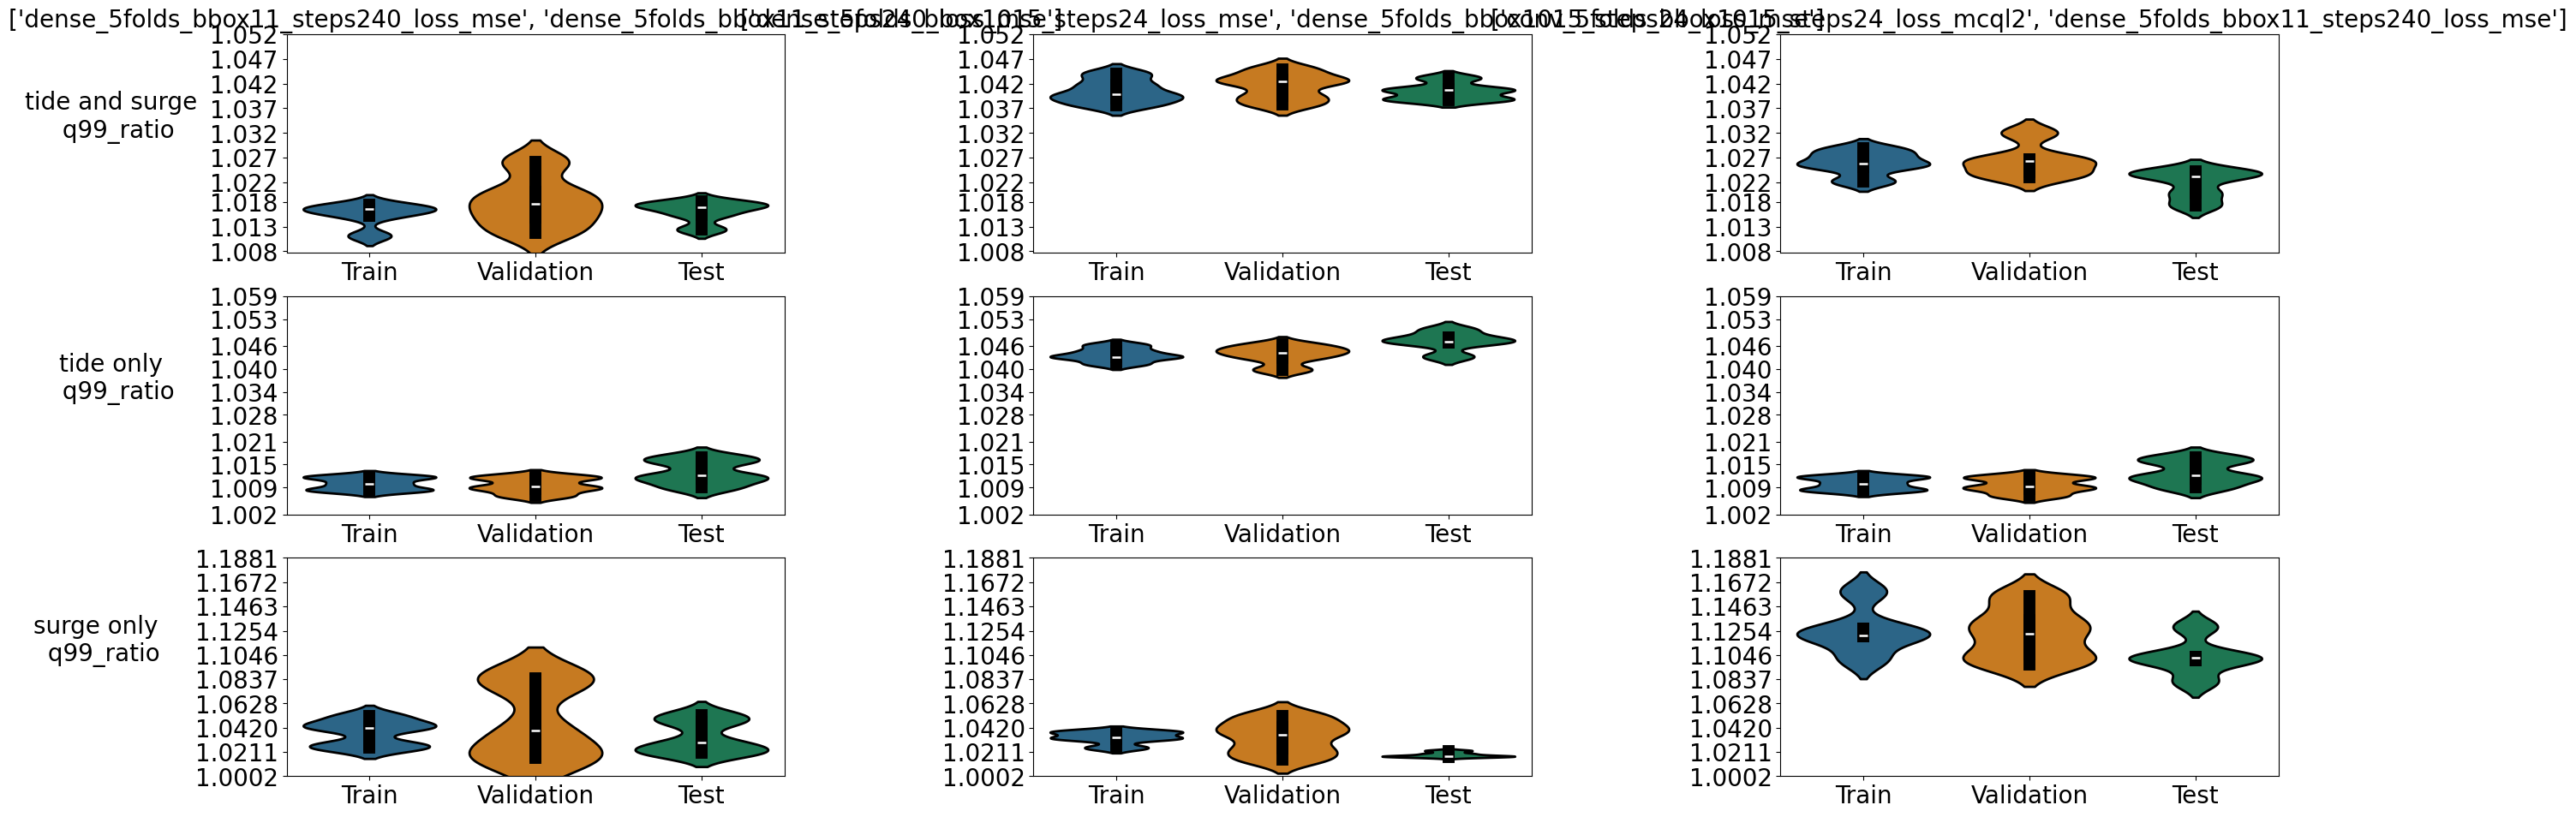

In [223]:
colors = [palette_hex_list[1],palette_hex_list[6], palette_hex_list[3]]

# Crea la figura principale
fig = plt.figure(figsize=(30, 30))

# Crea un layout a griglia principale 3x1
outer_grid = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1], hspace=0.5)

# Crea un layout a griglia per il primo subplot principale con 2x3
inner_grid = gridspec.GridSpecFromSubplotSpec(3, len(models_to_analyze), subplot_spec=outer_grid[0], wspace=0.5)

for i in range(0,len(models_to_analyze)):

    train_mse = []
    train_mse.append(train_scores[0][2][i])
    train_mse.append(train_scores[1][2][i])
    train_mse.append(train_scores[2][2][i])
    train_mse.append(train_scores[3][2][i])
    train_mse.append(train_scores[4][2][i])

    val_mse = []
    val_mse.append(val_scores[0][2][i])
    val_mse.append(val_scores[1][2][i])
    val_mse.append(val_scores[2][2][i])
    val_mse.append(val_scores[3][2][i])
    val_mse.append(val_scores[4][2][i])

    test_mse = []
    test_mse.append(test_scores[0][2][i])
    test_mse.append(test_scores[1][2][i])
    test_mse.append(test_scores[2][2][i])
    test_mse.append(test_scores[3][2][i])
    test_mse.append(test_scores[4][2][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[0, i])
    ax.set_ylim((min_q99-(0.1*(max_q99-min_q99)),max_q99+(0.2*(max_q99-min_q99))))
    ax.set_yticks(np.round(np.linspace(min_q99-(0.1*(max_q99-min_q99)), max_q99+(0.2*(max_q99-min_q99)), 10),3))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(models_to_analyze[i], fontsize=20)
    if i == 0:
        ax.set_ylabel("tide and surge \n q99_ratio", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_tide[0][2][i])
    train_mse.append(train_scores_tide[1][2][i])
    train_mse.append(train_scores_tide[2][2][i])
    train_mse.append(train_scores_tide[3][2][i])
    train_mse.append(train_scores_tide[4][2][i])

    val_mse = []
    val_mse.append(val_scores_tide[0][2][i])
    val_mse.append(val_scores_tide[1][2][i])
    val_mse.append(val_scores_tide[2][2][i])
    val_mse.append(val_scores_tide[3][2][i])
    val_mse.append(val_scores_tide[4][2][i])

    test_mse = []
    test_mse.append(test_scores_tide[0][2][i])
    test_mse.append(test_scores_tide[1][2][i])
    test_mse.append(test_scores_tide[2][2][i])
    test_mse.append(test_scores_tide[3][2][i])
    test_mse.append(test_scores_tide[4][2][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[1, i])
    ax.set_ylim((min_q99_tide-(0.1*(max_q99_tide-min_q99_tide)),max_q99_tide+(0.2*(max_q99_tide-min_q99_tide))))
    ax.set_yticks(np.round(np.linspace(min_q99_tide-(0.1*(max_q99_tide-min_q99_tide)), max_q99_tide+(0.2*(max_q99_tide-min_q99_tide)), 10),3))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if i == 0:
        ax.set_ylabel("tide only \n q99_ratio", fontsize=20, rotation=0, labelpad=80)

    train_mse = []
    train_mse.append(train_scores_surge[0][2][i])
    train_mse.append(train_scores_surge[1][2][i])
    train_mse.append(train_scores_surge[2][2][i])
    train_mse.append(train_scores_surge[3][2][i])
    train_mse.append(train_scores_surge[4][2][i])

    val_mse = []
    val_mse.append(val_scores_surge[0][2][i])
    val_mse.append(val_scores_surge[1][2][i])
    val_mse.append(val_scores_surge[2][2][i])
    val_mse.append(val_scores_surge[3][2][i])
    val_mse.append(val_scores_surge[4][2][i])

    test_mse = []
    test_mse.append(test_scores_surge[0][2][i])
    test_mse.append(test_scores_surge[1][2][i])
    test_mse.append(test_scores_surge[2][2][i])
    test_mse.append(test_scores_surge[3][2][i])
    test_mse.append(test_scores_surge[4][2][i])

    # Subplot
    ax = fig.add_subplot(inner_grid[2, i])
    ax.set_ylim((min_q99_surge-(0.1*(max_q99_surge-min_q99_surge)),max_q99_surge+(0.2*(max_q99_surge-min_q99_surge))))
    ax.set_yticks(np.round(np.linspace(min_q99_surge-(0.1*(max_q99_surge-min_q99_surge)), max_q99_surge+(0.2*(max_q99_surge-min_q99_surge)), 10),4))
    sns.violinplot(
        data=[train_mse, val_mse, test_mse],
        bw_method=0.4,
        density_norm='width',
        palette=colors,
        linewidth=2  # Set the edge color to black
    )
    for violin in plt.gca().collections:
        violin.set_edgecolor('black')
    # Cambia il colore e le dimensioni del boxplot interno
    for artist in plt.gca().artists:
        # Imposta il colore e le dimensioni del boxplot
        artist.set_edgecolor('black')
        artist.set_linewidth(4)
    # Personalizza i boxplot interni
    for line in plt.gca().lines:
        line.set_color('black')
        line.set_linewidth(10)
    ax.set_xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if i == 0:
        ax.set_ylabel("surge only \n q99_ratio", fontsize=20, rotation=0, labelpad=80)
# Mostra il grafico
plt.show()

## Extremes analisys

## __________________________________________________________________________________________________________

In [224]:
include_test = True

def generate_hourly_dates(start_year, start_month, end_year, end_month):
    # Genera una data di inizio e una data di fine
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1, hour=0, minute=0)
    # Calcola l'ultimo giorno del mese di fine
    end_date = pd.Timestamp(year=end_year, month=end_month, day=1, hour=0, minute=0) + pd.offsets.MonthEnd(0) + pd.DateOffset(hour=23, minute=59)
    
    # Genera il vettore di date con passo orario
    date_range = pd.date_range(start=start_date, end=end_date, freq='h')
    return date_range


date_extremes_pred = [[],[],[],[],[]]
date_extremes_real = [[],[],[],[],[]]
exceedances_pred = [[],[],[],[],[]]
exceedances_real = [[],[],[],[],[]]

k = 0
for fold in range(1):
    k = k+1
    y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_train= np.load(y_train_name)
    if preprocess=="standardize":
        y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_val=np.load(y_val_name)
    if preprocess=="standardize":
        y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_test=np.load(y_test_name)
    if preprocess=="standardize":
        y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

    # quantile for exceedances threshold
    y= np.concatenate([y_train, y_val, y_test])
    y_cleaned = y[:,1]
    y_cleaned = y_cleaned[~np.isnan(y_cleaned)]
    threshold_surge = np.quantile(y_cleaned, 0.99)
    del y_cleaned

# Generazione del vettore di date
start_year = train_y_bounds[0]
start_month = train_month_start_end[0]
end_year = train_y_bounds[1]
end_month = train_month_start_end[1]
dates = generate_hourly_dates(start_year, start_month, end_year, end_month)
# (mancano steps recurrent iniziali)
# dates = dates[(LSTM_recurrent_steps-1):]

palette_list= [palette_hex_list[1],palette_hex_list[3],palette_hex_list[5],palette_hex_list[7],palette_hex_list[9]]

# Creazione dei subplot
#fig, axs = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)

for i, model_type in enumerate(models_to_analyze):
    train_val_indices = np.load(local_data_path+'train_val_indices.npy')
    test_indices = np.load(local_data_path+'test_indices.npy')
    arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
    arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
    color = palette_list[i % len(palette_list)]  # Cicla attraverso i colori
    
    k = 0
    for fold in range(folds_number):
        k = k+1

        # Caricamento dei valori inferiti
        y_train_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[0]}_"+preprocess+"_model/y_train_k"+str(fold)+"_predict.npy")
        tmp_y_train_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[1]}_"+preprocess+"_model/y_train_k"+str(fold)+"_predict.npy")
        y_train_predict[:,0] = tmp_y_train_predict[:,0] # tide from tide model (second one)
        del tmp_y_train_predict
        y_val_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[0]}_"+preprocess+"_model/y_val_k"+str(fold)+"_predict.npy")
        tmp_y_val_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[1]}_"+preprocess+"_model/y_val_k"+str(fold)+"_predict.npy")
        y_val_predict[:,0] = tmp_y_val_predict[:,0] # tide from tide model (second one)
        del tmp_y_val_predict
        y_test_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[0]}_"+preprocess+"_model/y_test_k"+str(fold)+"_predict.npy")
        tmp_y_test_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[1]}_"+preprocess+"_model/y_test_k"+str(fold)+"_predict.npy")
        y_test_predict[:,0] = tmp_y_test_predict[:,0] # tide from tide model (second one)
        del tmp_y_test_predict  

        if preprocess=="standardize":
            y_train_predict[:,0] = y_train_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_train_predict[:,1] = y_train_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        if preprocess=="standardize":
            y_val_predict[:,0] = y_val_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_val_predict[:,1] = y_val_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        if preprocess=="standardize":
            y_test_predict[:,0] = y_test_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_test_predict[:,1] = y_test_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

        y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_train= np.load(y_train_name)
        if preprocess=="standardize":
            y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_val=np.load(y_val_name)
        if preprocess=="standardize":
            y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_test=np.load(y_test_name)
        if preprocess=="standardize":
            y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

        # Considera solo la seconda variabile
        y_train_predict = y_train_predict[:, 1]
        y_val_predict = y_val_predict[:, 1]
        y_test_predict = y_test_predict[:, 1]

        # Combinazione delle predizioni
        if include_test:
            y_predict = np.concatenate([y_val_predict, y_test_predict])
            y_real = np.concatenate([y_val[:, 1], y_test[:, 1]])
        else:
            y_predict = y_val_predict
            y_real = y_val[:, 1]
            
        # Usa gli indici generati da KFold per creare i set di training e validation
        dates_test = dates[test_indices]
        train_array_name = f'train_indices_fold_{k}'
        val_array_name = f'val_indices_fold_{k}'
        dates_train, dates_val = dates[arrays_train_indicies[train_array_name].astype(int)], dates[arrays_val_indicies[val_array_name].astype(int)]
        
        if include_test:
            dates_concat = np.concatenate([dates_val, dates_test], axis=0)

        else:
            dates_concat = dates_val
        
        
        # print("dates len: "+str(dates_concat.shape))
        # print("y_predict len: "+str(y_predict.shape))
        
        
        # Creazione del DataFrame per i valori predetti
        ts = pd.Series(data=y_predict, index=dates_concat)
        # extremes = get_extremes(ts, "POT", threshold=threshold_surge, r="24h")
        exceedances_pred[fold].append(ts.values)
        date_extremes_pred[fold].append(ts.index)

        # # Creazione del DataFrame per i valori reali
        ts_real = pd.Series(data=y_real, index=dates_concat)
        # extremes = get_extremes(ts_real, "POT", threshold=threshold_surge, r="24h")
        exceedances_real[fold].append(ts_real.values)
        date_extremes_real[fold].append(ts_real.index)
        



    flaten_date_extremes_pred = np.concatenate((
        date_extremes_pred[0][i],
        date_extremes_pred[1][i],
        date_extremes_pred[2][i],
        date_extremes_pred[3][i],
        date_extremes_pred[4][i]
    ),axis=0)

    flaten_date_extremes_real = np.concatenate((
        date_extremes_real[0][i],
        date_extremes_real[1][i],
        date_extremes_real[2][i],
        date_extremes_real[3][i],
        date_extremes_real[4][i]
    ),axis=0)

    flaten_exceedance_pred = np.concatenate((
        exceedances_pred[0][i],
        exceedances_pred[1][i],
        exceedances_pred[2][i],
        exceedances_pred[3][i],
        exceedances_pred[4][i]
    ),axis=0)

    flaten_exceedance_real = np.concatenate((
        exceedances_real[0][i],
        exceedances_real[1][i],
        exceedances_real[2][i],
        exceedances_real[3][i],
        exceedances_real[4][i]
    ),axis=0)

    threshold_surge_pred = np.quantile(flaten_exceedance_pred, 0.99)

    # Fitting della distribuzione GPD ai valori sopra la soglia
    
    ts_real = pd.Series(data=flaten_exceedance_real, index=flaten_date_extremes_real)
    ts_real = ts_real.groupby(ts_real.index).mean()
    ts_real = ts_real.sort_index()
    model_real = EVA(ts_real)
    model_real.get_extremes( "POT", threshold=threshold_surge, r="24h")
    model_real.fit_model()
    rp_real = model_real.get_summary(
                                        return_period=np.logspace(0, 3, num=1000),
                                        alpha=0.90,
                                        n_samples=1000,
                                    )

    ts_pred = pd.Series(data=flaten_exceedance_pred, index=flaten_date_extremes_pred)
    ts_pred = ts_pred.groupby(ts_pred.index).mean()
    ts_pred = ts_pred.sort_index()
    model_pred = EVA(ts_pred)
    model_pred.get_extremes( "POT", threshold=threshold_surge_pred, r="24h")
    model_pred.fit_model()

    rp_pred = model_pred.get_summary(
                                        return_period=np.logspace(0, 3, num=1000),
                                        alpha=0.90,
                                        n_samples=1000,
                                    )



In [225]:
threshold_surge_pred

0.3466664126515383

return period
1.000000       0.649635
1.006939       0.650915
1.013925       0.652193
1.020961       0.653453
1.028045       0.654590
                 ...   
972.720319     3.154352
979.469667     3.159131
986.265846     3.163917
993.109181     3.168710
1000.000000    3.173510
Name: upper ci, Length: 1000, dtype: float64
1:  -0.0400887921141173
return period
1.000000       0.649635
1.006939       0.650915
1.013925       0.652193
1.020961       0.653453
1.028045       0.654590
                 ...   
972.720319     3.154352
979.469667     3.159131
986.265846     3.163917
993.109181     3.168710
1000.000000    3.173510
Name: upper ci, Length: 1000, dtype: float64
10:  -0.04942015402863499
return period
1.000000       0.649635
1.006939       0.650915
1.013925       0.652193
1.020961       0.653453
1.028045       0.654590
                 ...   
972.720319     3.154352
979.469667     3.159131
986.265846     3.163917
993.109181     3.168710
1000.000000    3.173510
Name: upper ci, Length: 10

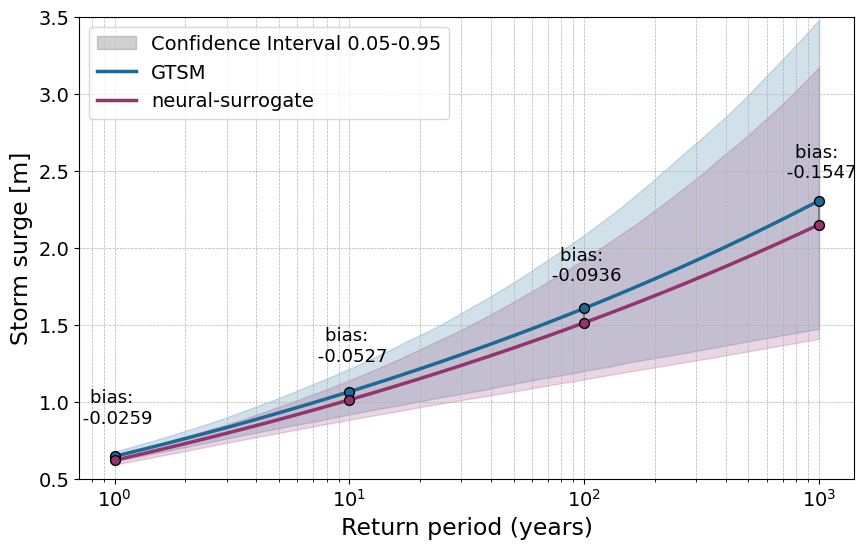

In [226]:
import matplotlib.patches as mpatches
# Plot della mediana e degli intervalli di confidenza
plt.figure(figsize=(10, 6))

# Plot della linea mediana
plt.plot(rp_real.index, rp_real['return value'], color=palette_hex_list[1], linewidth=2.5, label="GTSM")
# Plot dell'area di confidenza (ci) colorata con bordi tratteggiati
plt.fill_between(
    rp_real.index, rp_real['lower ci'], rp_real['upper ci'],
    color=palette_hex_list[1], alpha=0.2, edgecolor=palette_hex_list[1], linestyle='-', linewidth=1
)
# Plot della linea mediana
plt.plot(rp_pred.index, rp_pred['return value'], color=palette_hex_list[8], linewidth=2.5, label="neural-surrogate")
# Plot dell'area di confidenza (ci) colorata con bordi tratteggiati
plt.fill_between(
    rp_pred.index, rp_pred['lower ci'], rp_pred['upper ci'],
    color=palette_hex_list[8], alpha=0.2, edgecolor=palette_hex_list[8], linestyle='-', linewidth=1
)

specific_periods = [1 ,10, 100, 500, 1000]

# Aggiunta degli scatter per i soli tempi di ritorno specificati e dei segmenti con distanza
for period in specific_periods:
    if period in rp_real.index and period in rp_pred.index:
        # Valori di return per rp_real e rp_pred
        real_value = rp_real.loc[period, "return value"]
        pred_value = rp_pred.loc[period, "return value"]
        
        # Scatter plot
        plt.scatter(period, real_value, color=palette_hex_list[1], edgecolor="black", s=50, zorder=5)
        plt.scatter(period, pred_value, color=palette_hex_list[8], edgecolor="black", s=50, zorder=5)
        print(rp_pred['upper ci'])
        # Linea che collega i punti
        plt.plot([period, period], [real_value, pred_value], color="grey", linestyle="-", linewidth=1.5)
        
        # Testo con la distanza
        distance = (pred_value  - real_value)
        print(str(period)+":  "+str(distance/real_value))
        plt.text(period, (real_value + pred_value) / 2 + 0.2, f"bias: \n {distance:.4f}", ha="center", va="bottom", fontsize=13, color="black")

plt.ylim([0.5,3.5])
# Dettagli del grafico
plt.xlabel("Return period (years)",fontsize=17)
plt.ylabel("Storm surge [m]",fontsize=17)
plt.xscale("log")
plt.xticks(fontsize=14)  # Aumenta la dimensione dei numeri sull'asse x
plt.yticks(fontsize=14)  # Aumenta la dimensione dei numeri sull'asse y
# plt.title("Return period and confidence interval")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
shadow_patch = mpatches.Patch(color=palette_hex_list[11], alpha=0.3, label="Confidence Interval 0.05-0.95")
plt.legend(handles=[shadow_patch] + plt.gca().get_legend_handles_labels()[0], fontsize=14, loc="upper left")
# plt.show()
plt.savefig("img_paper/era5_return_mse.pdf", format="pdf", bbox_inches="tight", dpi=400)

In [52]:
include_test = True

def generate_hourly_dates(start_year, start_month, end_year, end_month):
    # Genera una data di inizio e una data di fine
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1, hour=0, minute=0)
    # Calcola l'ultimo giorno del mese di fine
    end_date = pd.Timestamp(year=end_year, month=end_month, day=1, hour=0, minute=0) + pd.offsets.MonthEnd(0) + pd.DateOffset(hour=23, minute=59)
    
    # Genera il vettore di date con passo orario
    date_range = pd.date_range(start=start_date, end=end_date, freq='h')
    return date_range


date_extremes_pred = [[],[],[],[],[]]
date_extremes_real = [[],[],[],[],[]]
exceedances_pred = [[],[],[],[],[]]
exceedances_real = [[],[],[],[],[]]

k = 0
for fold in range(1):
    k = k+1
    y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_train= np.load(y_train_name)
    if preprocess=="standardize":
        y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_val=np.load(y_val_name)
    if preprocess=="standardize":
        y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_test=np.load(y_test_name)
    if preprocess=="standardize":
        y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

    # quantile for exceedances threshold
    y= np.concatenate([y_train, y_val, y_test])
    y_cleaned = y[:,1]+y[:,0]
    y_cleaned = y_cleaned[~np.isnan(y_cleaned)]
    threshold_surge = np.quantile(y_cleaned, 0.99)
    del y_cleaned

# Generazione del vettore di date
start_year = train_y_bounds[0]
start_month = train_month_start_end[0]
end_year = train_y_bounds[1]
end_month = train_month_start_end[1]
dates = generate_hourly_dates(start_year, start_month, end_year, end_month)
# (mancano steps recurrent iniziali)
# dates = dates[(LSTM_recurrent_steps-1):]

palette_list= [palette_hex_list[1],palette_hex_list[3],palette_hex_list[5],palette_hex_list[7],palette_hex_list[9]]

# Creazione dei subplot
# fig, axs = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)

for i, model_type in enumerate(models_to_analyze):
    train_val_indices = np.load(local_data_path+'train_val_indices.npy')
    test_indices = np.load(local_data_path+'test_indices.npy')
    arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
    arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
    color = palette_list[i % len(palette_list)]  # Cicla attraverso i colori
    
    k = 0
    for fold in range(folds_number):
        k = k+1
        
        
        # Caricamento dei valori inferiti
        y_train_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[0]}_"+preprocess+"_model/y_train_k"+str(fold)+"_predict.npy")
        tmp_y_train_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[1]}_"+preprocess+"_model/y_train_k"+str(fold)+"_predict.npy")
        y_train_predict[:,0] = tmp_y_train_predict[:,0] # tide from tide model (second one)
        del tmp_y_train_predict
        y_val_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[0]}_"+preprocess+"_model/y_val_k"+str(fold)+"_predict.npy")
        tmp_y_val_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[1]}_"+preprocess+"_model/y_val_k"+str(fold)+"_predict.npy")
        y_val_predict[:,0] = tmp_y_val_predict[:,0] # tide from tide model (second one)
        del tmp_y_val_predict
        y_test_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[0]}_"+preprocess+"_model/y_test_k"+str(fold)+"_predict.npy")
        tmp_y_test_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type[1]}_"+preprocess+"_model/y_test_k"+str(fold)+"_predict.npy")
        y_test_predict[:,0] = tmp_y_test_predict[:,0] # tide from tide model (second one)
        del tmp_y_test_predict  
        if preprocess=="standardize":
            y_train_predict[:,0] = y_train_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_train_predict[:,1] = y_train_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        if preprocess=="standardize":
            y_val_predict[:,0] = y_val_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_val_predict[:,1] = y_val_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        if preprocess=="standardize":
            y_test_predict[:,0] = y_test_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_test_predict[:,1] = y_test_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

        y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_train= np.load(y_train_name)
        if preprocess=="standardize":
            y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_val=np.load(y_val_name)
        if preprocess=="standardize":
            y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
        y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
        y_test=np.load(y_test_name)
        if preprocess=="standardize":
            y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
            y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

        # Considera solo la seconda variabile
        y_train_predict = y_train_predict[:, 1]+y_train_predict[:, 0]
        y_val_predict = y_val_predict[:, 1]+y_val_predict[:, 0]
        y_test_predict = y_test_predict[:, 1]+y_test_predict[:, 0]

        # Combinazione delle predizioni
        if include_test:
            y_predict = np.concatenate([y_val_predict, y_test_predict])
            y_real = np.concatenate([y_val[:, 1]+y_val[:, 0], y_test[:, 1]+y_test[:, 0]])
        else:
            y_predict = y_val_predict
            y_real = y_val[:, 1]+y_val[:, 0]
            
        # Usa gli indici generati da KFold per creare i set di training e validation
        dates_test = dates[test_indices]
        train_array_name = f'train_indices_fold_{k}'
        val_array_name = f'val_indices_fold_{k}'
        dates_train, dates_val = dates[arrays_train_indicies[train_array_name].astype(int)], dates[arrays_val_indicies[val_array_name].astype(int)]
        
        if include_test:
            dates_concat = np.concatenate([dates_val, dates_test], axis=0)

        else:
            dates_concat = dates_val
        # print("dates len: "+str(dates_concat.shape))
        # print("y_predict len: "+str(y_predict.shape))
        
        
        # Creazione del DataFrame per i valori predetti
        ts = pd.Series(data=y_predict, index=dates_concat)
        # extremes = get_extremes(ts, "POT", threshold=threshold_surge, r="24h")
        exceedances_pred[fold].append(ts.values)
        date_extremes_pred[fold].append(ts.index)

        # # Creazione del DataFrame per i valori reali
        ts_real = pd.Series(data=y_real, index=dates_concat)
        # extremes = get_extremes(ts_real, "POT", threshold=threshold_surge, r="24h")
        exceedances_real[fold].append(ts_real.values)
        date_extremes_real[fold].append(ts_real.index)
        



    flaten_date_extremes_pred = np.concatenate((
        date_extremes_pred[0][i],
        date_extremes_pred[1][i],
        date_extremes_pred[2][i],
        date_extremes_pred[3][i],
        date_extremes_pred[4][i]
    ),axis=0)

    flaten_date_extremes_real = np.concatenate((
        date_extremes_real[0][i],
        date_extremes_real[1][i],
        date_extremes_real[2][i],
        date_extremes_real[3][i],
        date_extremes_real[4][i]
    ),axis=0)

    flaten_exceedance_pred = np.concatenate((
        exceedances_pred[0][i],
        exceedances_pred[1][i],
        exceedances_pred[2][i],
        exceedances_pred[3][i],
        exceedances_pred[4][i]
    ),axis=0)

    flaten_exceedance_real = np.concatenate((
        exceedances_real[0][i],
        exceedances_real[1][i],
        exceedances_real[2][i],
        exceedances_real[3][i],
        exceedances_real[4][i]
    ),axis=0)

    threshold_surge_pred = np.quantile(flaten_exceedance_pred, 0.99)
    # Fitting della distribuzione GPD ai valori sopra la soglia
    
    ts_real = pd.Series(data=flaten_exceedance_real, index=flaten_date_extremes_real)
    ts_real = ts_real.groupby(ts_real.index).mean()
    ts_real = ts_real.sort_index()
    model_real = EVA(ts_real)
    model_real.get_extremes( "POT", threshold=threshold_surge, r="24h")
    model_real.fit_model()
    rp_real = model_real.get_summary(
                                        return_period=np.logspace(0, 3, num=1000),
                                        alpha=0.90,
                                        n_samples=1000,
                                    )

    ts_pred = pd.Series(data=flaten_exceedance_pred, index=flaten_date_extremes_pred)
    ts_pred = ts_pred.groupby(ts_pred.index).mean()
    ts_pred = ts_pred.sort_index()
    model_pred = EVA(ts_pred)
    model_pred.get_extremes( "POT", threshold=threshold_surge_pred, r="24h")
    model_pred.fit_model()

    rp_pred = model_pred.get_summary(
                                        return_period=np.logspace(0, 3, num=1000),
                                        alpha=0.90,
                                        n_samples=1000,
                                    )



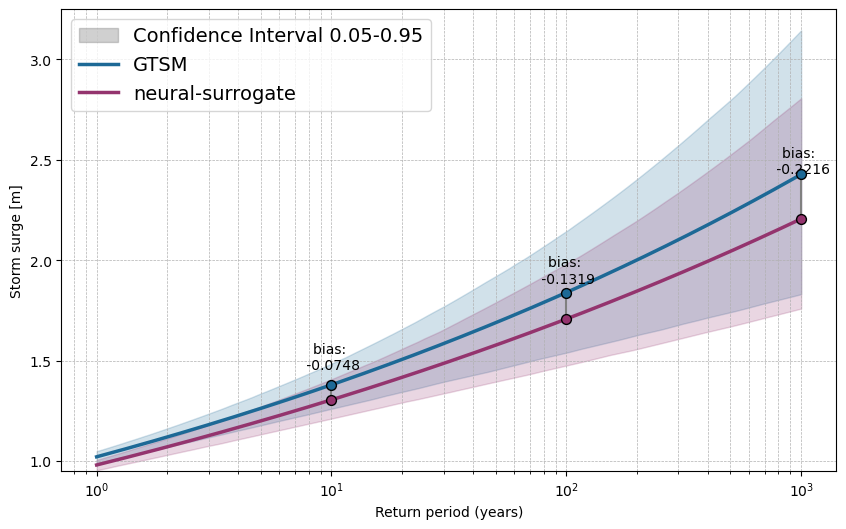

In [53]:
import matplotlib.patches as mpatches
# Plot della mediana e degli intervalli di confidenza
plt.figure(figsize=(10, 6))

# Plot della linea mediana
plt.plot(rp_real.index, rp_real['return value'], color=palette_hex_list[1], linewidth=2.5, label="GTSM")
# Plot dell'area di confidenza (ci) colorata con bordi tratteggiati
plt.fill_between(
    rp_real.index, rp_real['lower ci'], rp_real['upper ci'],
    color=palette_hex_list[1], alpha=0.2, edgecolor=palette_hex_list[1], linestyle='-', linewidth=1
)
# Plot della linea mediana
plt.plot(rp_pred.index, rp_pred['return value'], color=palette_hex_list[8], linewidth=2.5, label="neural-surrogate")
# Plot dell'area di confidenza (ci) colorata con bordi tratteggiati
plt.fill_between(
    rp_pred.index, rp_pred['lower ci'], rp_pred['upper ci'],
    color=palette_hex_list[8], alpha=0.2, edgecolor=palette_hex_list[8], linestyle='-', linewidth=1
)
specific_periods = [10, 100, 500, 1000]

# Aggiunta degli scatter per i soli tempi di ritorno specificati e dei segmenti con distanza
for period in specific_periods:
    if period in rp_real.index and period in rp_pred.index:
        # Valori di return per rp_real e rp_pred
        real_value = rp_real.loc[period, "return value"]
        pred_value = rp_pred.loc[period, "return value"]
        
        # Scatter plot
        plt.scatter(period, real_value, color=palette_hex_list[1], edgecolor="black", s=50, zorder=5)
        plt.scatter(period, pred_value, color=palette_hex_list[8], edgecolor="black", s=50, zorder=5)
        
        # Linea che collega i punti
        plt.plot([period, period], [real_value, pred_value], color="grey", linestyle="-", linewidth=1.5)
        
        # Testo con la distanza
        distance = (pred_value  - real_value)
        plt.text(period, (real_value + pred_value) / 2 + 0.1, f"bias: \n {distance:.4f}", ha="center", va="bottom", fontsize=10, color="black")

plt.ylim([0.95,3.25])
# Dettagli del grafico
plt.xlabel("Return period (years)")
plt.ylabel("Storm surge [m]")
plt.xscale("log")
# plt.title("Return period and confidence interval")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
shadow_patch = mpatches.Patch(color=palette_hex_list[11], alpha=0.3, label="Confidence Interval 0.05-0.95")
plt.legend(handles=[shadow_patch] + plt.gca().get_legend_handles_labels()[0], fontsize=14, loc="upper left")
plt.show()


## Trajectories and peaks

In [62]:
column_names_tmp=column_names[0:5]
# Creiamo un DataFrame temporaneo che combina tutti i valori delle prime 5 colonne in una singola serie
combined_data = []

for col in column_names_tmp:
    # Crea un DataFrame temporaneo con i valori della colonna, l'indice come date, e aggiungi il nome della colonna
    col_data = df_surge[col].dropna().reset_index()  # Resetta l'indice per rendere 'Data' una colonna
    col_data.columns = ['Data', 'Valore']  # Rinomina le colonne per chiarezza
    col_data['Colonna'] = col  # Aggiungi una colonna per specificare la provenienza del valore
    combined_data.append(col_data)

# Combina tutte le serie in un unico DataFrame
combined_df = pd.concat(combined_data)
# Assicura che la colonna 'Valore' sia di tipo numerico
combined_df['Valore'] = pd.to_numeric(combined_df['Valore'], errors='coerce')

# Trova i 10 valori massimi tra tutte le colonne
top_10_values = combined_df.nlargest(20, 'Valore')

# Stampa il risultato
print(top_10_values)

                     Data  Valore Colonna
50354 2012-10-30 02:00:00   2.408  k3_val
50353 2012-10-30 01:00:00   2.390  k3_val
50352 2012-10-30 00:00:00   2.186  k3_val
50355 2012-10-30 03:00:00   2.057  k3_val
50351 2012-10-29 23:00:00   1.959  k3_val
50356 2012-10-30 04:00:00   1.722  k3_val
50350 2012-10-29 22:00:00   1.719  k3_val
50349 2012-10-29 21:00:00   1.552  k3_val
50357 2012-10-30 05:00:00   1.546  k3_val
50358 2012-10-30 06:00:00   1.412  k3_val
50348 2012-10-29 20:00:00   1.376  k3_val
50359 2012-10-30 07:00:00   1.297  k3_val
50360 2012-10-30 08:00:00   1.196  k3_val
2126  1984-03-29 14:00:00   1.161  k5_val
2127  1984-03-29 15:00:00   1.137  k5_val
50347 2012-10-29 19:00:00   1.121  k3_val
15233 1985-09-27 17:00:00   1.116  k1_val
40860 2011-08-28 12:00:00   1.056  k5_val
2128  1984-03-29 16:00:00   1.049  k5_val
50361 2012-10-30 09:00:00   1.043  k3_val


In [55]:
column_names_tmp=column_names[5:6]
# Creiamo un DataFrame temporaneo che combina tutti i valori delle prime 5 colonne in una singola serie
combined_data = []

for col in column_names_tmp:
    # Crea un DataFrame temporaneo con i valori della colonna, l'indice come date, e aggiungi il nome della colonna
    col_data = df_surge[col].dropna().reset_index()  # Resetta l'indice per rendere 'Data' una colonna
    col_data.columns = ['Data', 'Valore']  # Rinomina le colonne per chiarezza
    col_data['Colonna'] = col  # Aggiungi una colonna per specificare la provenienza del valore
    combined_data.append(col_data)

# Combina tutte le serie in un unico DataFrame
combined_df = pd.concat(combined_data)
# Assicura che la colonna 'Valore' sia di tipo numerico
combined_df['Valore'] = pd.to_numeric(combined_df['Valore'], errors='coerce')

# Trova i 10 valori massimi tra tutte le colonne
top_10_values = combined_df.nlargest(50, 'Valore')

# Stampa il risultato
print(top_10_values)

                     Data  Valore  Colonna
16417 1995-11-15 01:00:00   1.024  k1_test
28032 2010-03-14 00:00:00   0.968  k1_test
16416 1995-11-15 00:00:00   0.947  k1_test
28031 2010-03-13 23:00:00   0.923  k1_test
28033 2010-03-14 01:00:00   0.916  k1_test
16418 1995-11-15 02:00:00   0.873  k1_test
28030 2010-03-13 22:00:00   0.823  k1_test
28034 2010-03-14 02:00:00   0.754  k1_test
28037 2010-03-14 05:00:00   0.750  k1_test
28038 2010-03-14 06:00:00   0.750  k1_test
16415 1995-11-14 23:00:00   0.736  k1_test
28039 2010-03-14 07:00:00   0.734  k1_test
16423 1995-11-15 07:00:00   0.732  k1_test
16422 1995-11-15 06:00:00   0.727  k1_test
28040 2010-03-14 08:00:00   0.721  k1_test
28029 2010-03-13 21:00:00   0.714  k1_test
16424 1995-11-15 08:00:00   0.709  k1_test
28036 2010-03-14 04:00:00   0.706  k1_test
28041 2010-03-14 09:00:00   0.699  k1_test
16419 1995-11-15 03:00:00   0.690  k1_test
28035 2010-03-14 03:00:00   0.682  k1_test
16351 1995-11-12 07:00:00   0.663  k1_test
16421 1995-

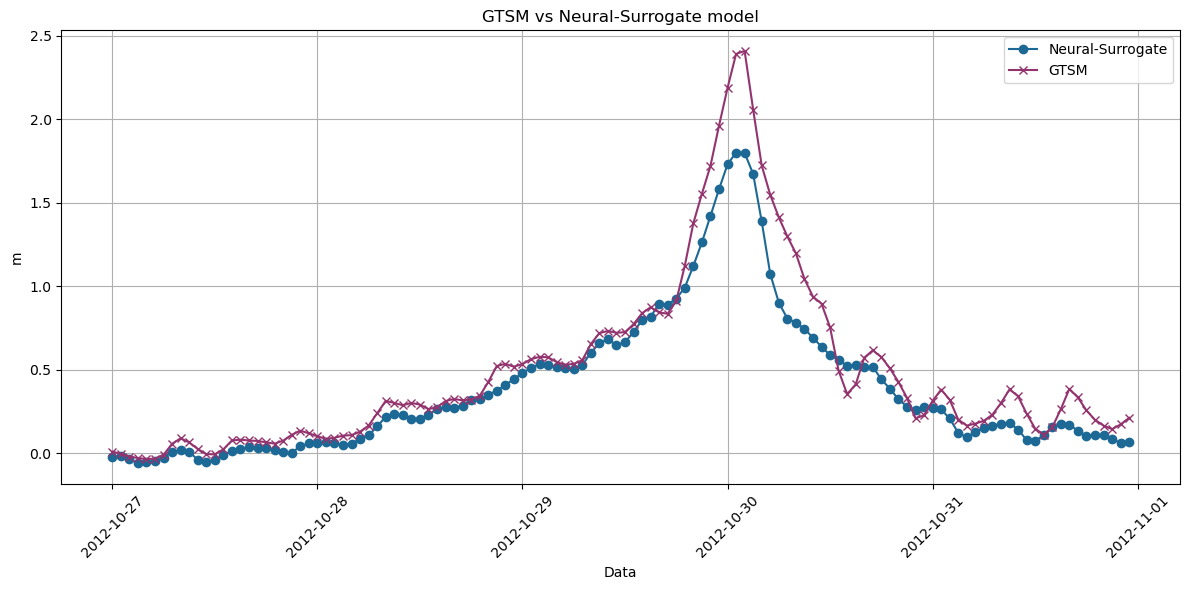

In [56]:
# NY Sandy
selected_dates = pd.date_range(start='2012-10-27 00:00', end='2012-10-31 23:00', freq='h')
# BEIRA Lisette
# selected_dates = pd.date_range(start='1997-02-28 21:00', end='1997-03-02 21:00', freq='h')
# OSAKA Jebi
# selected_dates = pd.date_range(start='2018-09-02 21:00', end='2018-09-06 21:00', freq='h')


selected_rows = df_surge_pred.loc[selected_dates]
filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_surge.loc[selected_dates]
filtered_values = selected_rows.dropna(axis=1, how='all')
selected_rows = df_tide_pred.loc[selected_dates]
tide_filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_tide.loc[selected_dates]
tide_filtered_values = selected_rows.dropna(axis=1, how='all')


# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(filtered_values_pred, label='Neural-Surrogate', color=palette_hex_list[1], linestyle='-', marker='o')
plt.plot(filtered_values, label='GTSM', color=palette_hex_list[8], linestyle='-', marker='x')
plt.title('GTSM vs Neural-Surrogate model')
plt.xlabel('Data')
plt.ylabel('m')
plt.legend()

# Miglioramento della leggibilità delle date sull'asse X
plt.xticks(rotation=45)
plt.grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

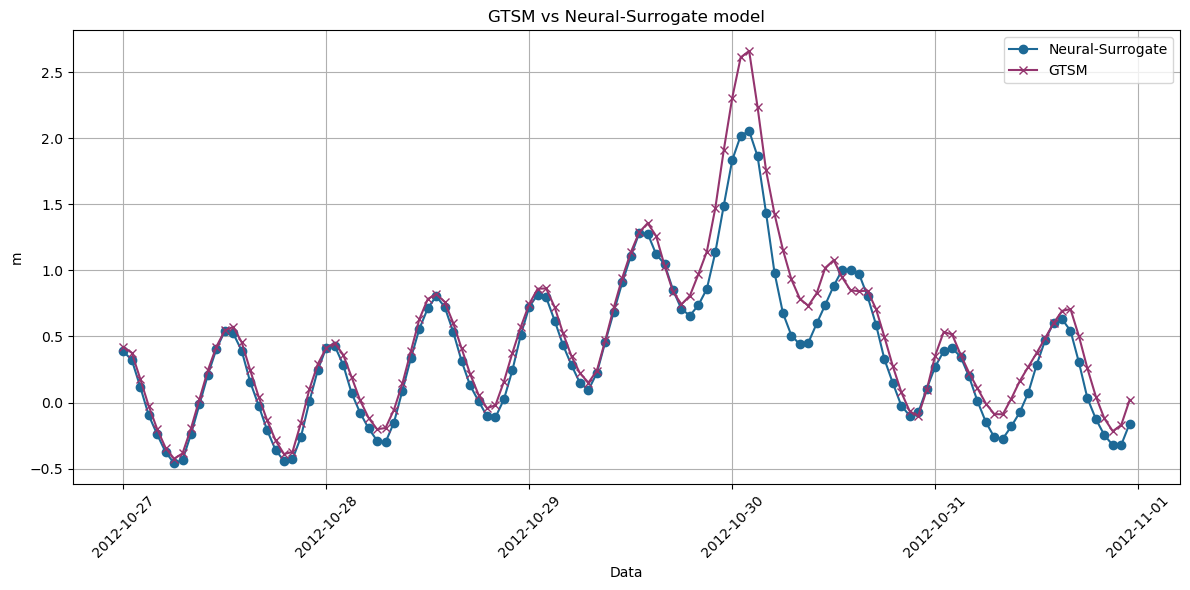

In [57]:
selected_rows = df_surge_pred.loc[selected_dates]
filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_surge.loc[selected_dates]
filtered_values = selected_rows.dropna(axis=1, how='all')
selected_rows = df_tide_pred.loc[selected_dates]
tide_filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_tide.loc[selected_dates]
tide_filtered_values = selected_rows.dropna(axis=1, how='all')


# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(filtered_values_pred+tide_filtered_values_pred, label='Neural-Surrogate', color=palette_hex_list[1], linestyle='-', marker='o')
plt.plot(filtered_values+tide_filtered_values, label='GTSM', color=palette_hex_list[8], linestyle='-', marker='x')
plt.title('GTSM vs Neural-Surrogate model')
plt.xlabel('Data')
plt.ylabel('m')
plt.legend()

# Miglioramento della leggibilità delle date sull'asse X
plt.xticks(rotation=45)
plt.grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

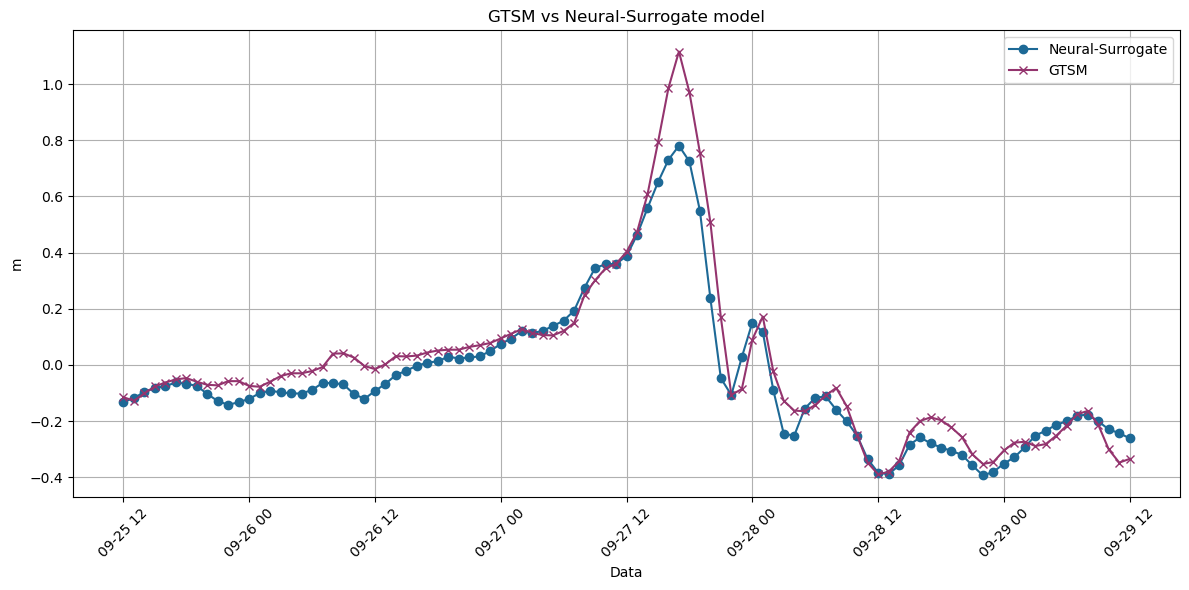

In [58]:
# Hurricane Gloria
selected_dates = pd.date_range(start='1985-09-25 12:00', end='1985-09-29 12:00', freq='h')
# BEIRA 
# selected_dates = pd.date_range(start='2009-03-20 19:00', end='2009-03-22 19:00', freq='h')
# OSAKA 
# selected_dates = pd.date_range(start='2004-08-28 21:00', end='2004-08-31 21:00', freq='h')


selected_rows = df_surge_pred.loc[selected_dates]
filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_surge.loc[selected_dates]
filtered_values = selected_rows.dropna(axis=1, how='all')
selected_rows = df_tide_pred.loc[selected_dates]
tide_filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_tide.loc[selected_dates]
tide_filtered_values = selected_rows.dropna(axis=1, how='all')


# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(filtered_values_pred, label='Neural-Surrogate', color=palette_hex_list[1], linestyle='-', marker='o')
plt.plot(filtered_values, label='GTSM', color=palette_hex_list[8], linestyle='-', marker='x')
plt.title('GTSM vs Neural-Surrogate model')
plt.xlabel('Data')
plt.ylabel('m')
plt.legend()

# Miglioramento della leggibilità delle date sull'asse X
plt.xticks(rotation=45)
plt.grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

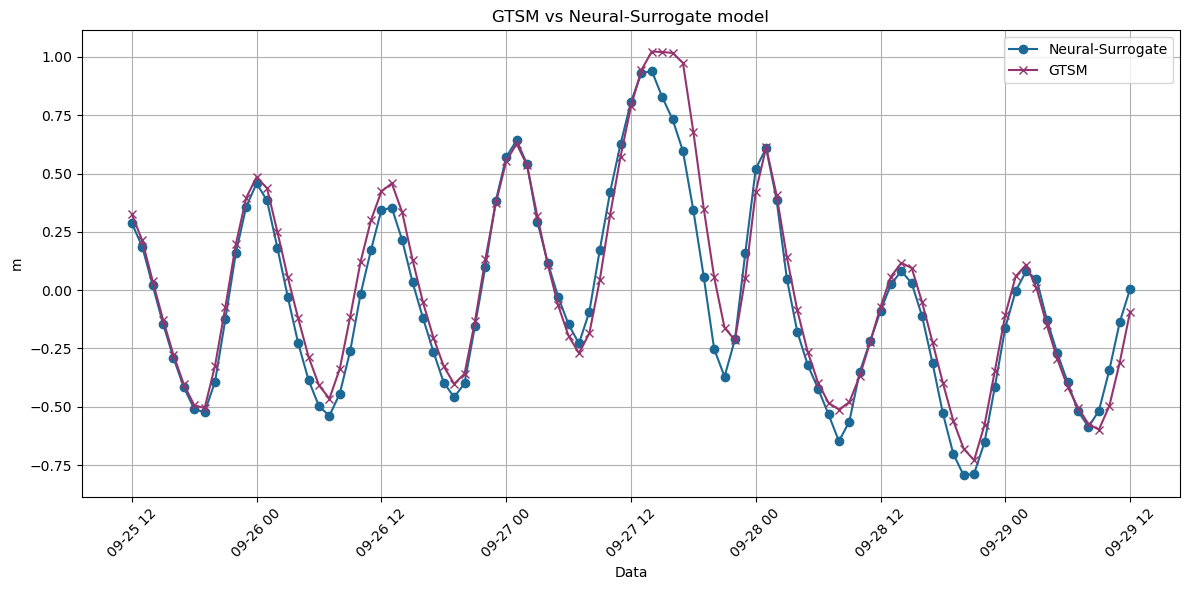

In [59]:
selected_rows = df_surge_pred.loc[selected_dates]
filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_surge.loc[selected_dates]
filtered_values = selected_rows.dropna(axis=1, how='all')
selected_rows = df_tide_pred.loc[selected_dates]
tide_filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_tide.loc[selected_dates]
tide_filtered_values = selected_rows.dropna(axis=1, how='all')


# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(filtered_values_pred+tide_filtered_values_pred, label='Neural-Surrogate', color=palette_hex_list[1], linestyle='-', marker='o')
plt.plot(filtered_values+tide_filtered_values, label='GTSM', color=palette_hex_list[8], linestyle='-', marker='x')
plt.title('GTSM vs Neural-Surrogate model')
plt.xlabel('Data')
plt.ylabel('m')
plt.legend()

# Miglioramento della leggibilità delle date sull'asse X
plt.xticks(rotation=45)
plt.grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

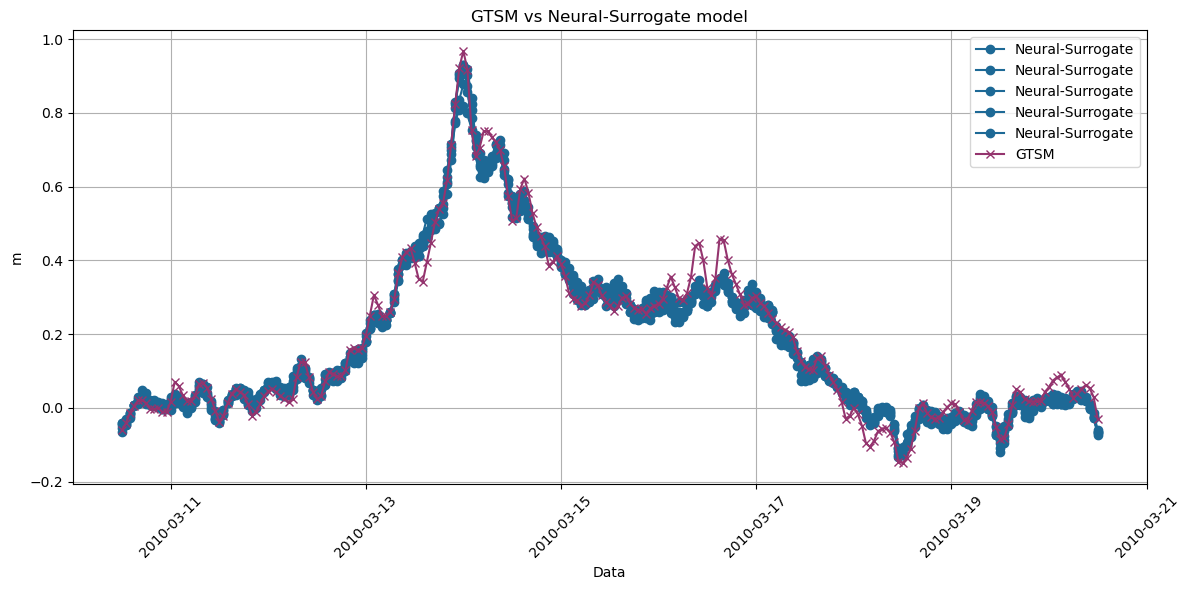

In [60]:
# NY newsday.com "Saturday storm packed bigger punch than some hurricanes" 2010 14 mar
selected_dates = pd.date_range(start='2010-03-10 12:00', end='2010-03-20 12:00', freq='h')
# BEIRA
# selected_dates = pd.date_range(start='1995-10-30 17:00', end='1995-11-02 17:00', freq='h')
# OSAKA 
# selected_dates = pd.date_range(start='1980-09-09 21:00', end='1980-09-13 21:00', freq='h')


selected_rows = df_surge_pred.loc[selected_dates]
filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_surge.loc[selected_dates]
filtered_values = selected_rows.dropna(axis=1, how='all')
selected_rows = df_tide_pred.loc[selected_dates]
tide_filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_tide.loc[selected_dates]
tide_filtered_values = selected_rows.dropna(axis=1, how='all')


# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(filtered_values_pred, label='Neural-Surrogate', color=palette_hex_list[1], linestyle='-', marker='o')
plt.plot(filtered_values["k1_test"], label='GTSM', color=palette_hex_list[8], linestyle='-', marker='x')
plt.title('GTSM vs Neural-Surrogate model')
plt.xlabel('Data')
plt.ylabel('m')
plt.legend()

# Miglioramento della leggibilità delle date sull'asse X
plt.xticks(rotation=45)
plt.grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()

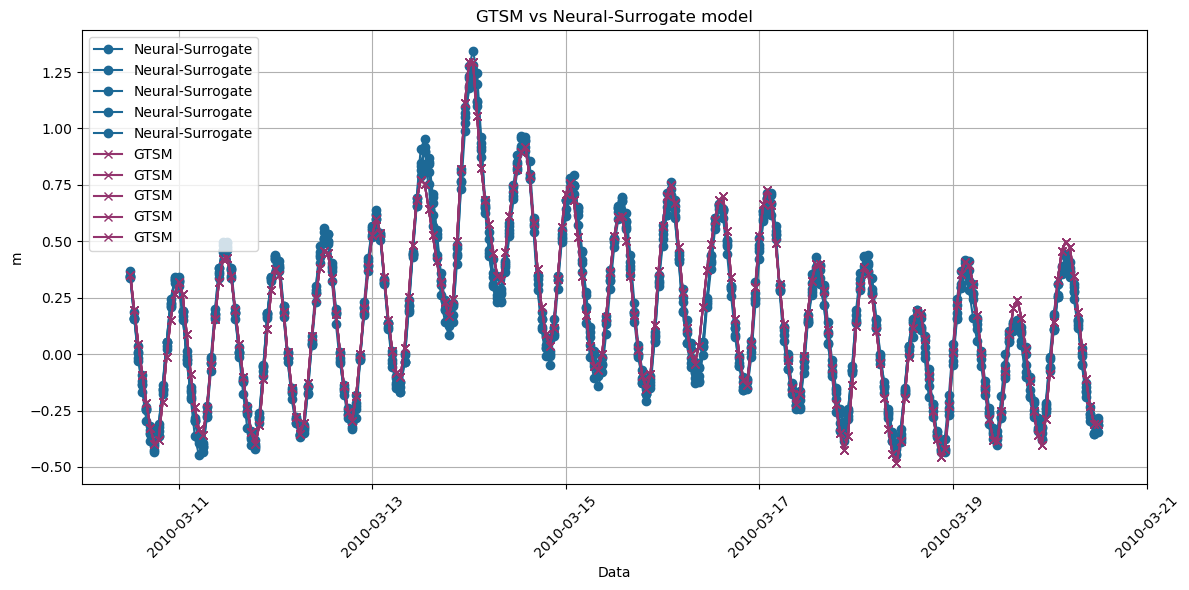

In [61]:

selected_rows = df_surge_pred.loc[selected_dates]
filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_surge.loc[selected_dates]
filtered_values = selected_rows.dropna(axis=1, how='all')
selected_rows = df_tide_pred.loc[selected_dates]
tide_filtered_values_pred = selected_rows.dropna(axis=1, how='all') 
selected_rows = df_tide.loc[selected_dates]
tide_filtered_values = selected_rows.dropna(axis=1, how='all')


# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(filtered_values_pred+tide_filtered_values_pred, label='Neural-Surrogate', color=palette_hex_list[1], linestyle='-', marker='o')
plt.plot(filtered_values+tide_filtered_values, label='GTSM', color=palette_hex_list[8], linestyle='-', marker='x')
plt.title('GTSM vs Neural-Surrogate model')
plt.xlabel('Data')
plt.ylabel('m')
plt.legend()

# Miglioramento della leggibilità delle date sull'asse X
plt.xticks(rotation=45)
plt.grid(True)

# Mostra il grafico
plt.tight_layout()
plt.show()